# Forecasting Daily Climate Events
### By: Nicolas Restrepo

## Section 1: Introduction

This project extracts data from 5 sources using a combination o APIs, Python libraries and bulk downloads as CSV files, to then pass the data through a MinMax Scaler to train a Multi-Layer Perceptron Regressor neural network and predict the maximum temperature of the next day (1 day into the future from the present day). This process is performed for the following cities in the United States: Miami, FL, New York, NY, Austin, TX, and Chicago, IL. After performing the predictions, an automatic trade is done on a Kalshi demo account through the Kalshi API to test and quantify the correctness and performance of the model over time. Each step in the process will be described in detail, as well as the decision process to choose this approach over other options. This report contains all the different steps and approaches evaluated during the process of arriving to the final model. The final model can be found towards the end of the report under "Section 7: Final Model". Finally, a series of graphs, images, and loss functions/indicators will be used to show the evolution of the model and the predictions thorughout time, using Kalshi and the trades made to further illustrate the accuracy of the model. 

## Section 2: Data Extraction
For the data extraction process, a variety of options were explored such as APIs, bulk downloads as CSV files, and even web-scraping. Web-scraping was discarded due to the excessive computational and time consumption it would require to get all of the desired data for the desired time-frames, so only APIs and bulk downloads were explored further. Most of the APIs available charged for historical data, especially for the desired time-frame: 2020-01-01 to 1 day before the current day (because most data for the current day is not available until at least the following day); but through extensive research, 2 APIs were found that provide this time-frame or almost this entire time-frame, and then 2 more were found that only provide the last 7 days of data but very accurately, which ended having a positive impact on the predictions. Some of the APIs had Python libraries implemented already, which simplified the data extraction process. Finally, the information from the APIs was complemented by the most up-to-date bulk download from the National Centers for Environmental Information (NCEI).

### Sources:
Source 1: API.weather.gov (https://www.weather.gov/documentation/services-web-api#/default/station_observation_list)

This API gives observations for a specific weather station for the last week. It gives multiple observations per day so it requires performing some operations to extract daily max, min and average values for temperature, pressure, etc. 

Source 2: Open Meteo API (https://open-meteo.com/en/docs/historical-weather-api#daily=temperature_2m_max)

This API had a Python library implemented, which made the extraction process easier by simply using the sample code provided in the documentation and adjusting it to the specific locations and features desired. The data from this API does not contain data from the previous day, so the prediction must be done with data 3 days before the predicted day.

Source 3: NCEI Bulk Download (https://www.ncei.noaa.gov/cdo-web/)

This source consisted of submitting an order (free) for the features and the time-frame desired for a specific location (weather station). Data was only available until the 15th or 16th of March 2024, depending on the city, so the labels had to be recalculated every day so the data was used to predict the desired date. This harms the accuracy of the prediction, but the source provides such accurate data that it was worth using and then complementing the accuracy of the prediction with recent, accurate data from other sources.

Source 4: Visual Crossing API (https://www.visualcrossing.com/weather/weather-data-services)

This API will bring data from the previous 7 days with respect to the current date, excluding the current day. It provides very precise data and is used to create a regression based on a small but complete set of data points that complements predictions performed with hundreds of data points.

Source 5: Meteostat API https://dev.meteostat.net/python/#installation

This API had a Python library implemented, which made the extraction process a lot easier since there was a great amount of starter code and usage instructions in the documentation. This source is able to provide data for the entire desired time-frame: 2020-01-01 to the day before the present day. 

### Imports for Data Extraction and Source Analysis

In [1]:
import numpy as np
import requests
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import sys
import json
import requests_cache
from meteostat import Daily, units
import math
import uuid
import kalshi_python
from kalshi_python.models import *
from pprint import pprint
from collections import defaultdict
from datetime import date

### Source 1: Weather.gov API
For this source, different API endpoints returned the station ID that was closest to the coordinates used for each city in all sources. The coordinates represent a weather station in each city; in Miami, the chosen weather station is at the Miami International Airport, in Chicago, the chosen weather station is at Midway Airport, in New York, its in Belvedere Castle in Central Park, and in Austin, its in Camp Mabry. Once the station ID was retrieved, another request is made to the API requesting observations for this particular station in the range of 7 days before the current day and 1 day before the current day. This request returns multiple observations per day, so a series of operations inside a loop have to be done to calculate daily observations, each containing: max. temperature, min. temperature, average temperature, average atmospheric pressure, average wind speed, and total precipitation for each day in the range. Finally, the labels are attached to the same resulting data frame. These are calculated by assigning each data point the maximum temperature of 2 days in the future as a label, this because in the present day, the maximum temperature of the next day will be predicted using the maximum temperature of the previous day.

#### Miami

In [2]:
# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.replace(hour=23, minute=59, second=59).strftime('%Y-%m-%dT%H:%M:%SZ')
yesterday_str = yesterday_str.replace(':', '%3A')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
start_date = datetime.now() - timedelta(7)
start_date_str = start_date.replace(hour=0, minute=0, second=0).strftime('%Y-%m-%dT%H:%M:%SZ')
start_date_str = start_date_str.replace(':', '%3A')

# Station ID never changes so the code to get it was deleted for simplicity
station_id = 'KMIA'

# Modify the URL to include the appropriate oparameters every day
observations_url = f"https://api.weather.gov/stations/{station_id}/observations?start={start_date_str}&end={yesterday_str}"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

daily_max_temperatures = {}

# Initialize dictionaries to store daily values
daily_min_temperatures = defaultdict(lambda: None)
daily_temperature_sums = defaultdict(int)
daily_temperature_counts = defaultdict(int)
daily_pressure_sums = defaultdict(int)
daily_pressure_counts = defaultdict(int)
daily_precipitation_sums = defaultdict(float)
daily_wind_speed_sums = defaultdict(float)
daily_wind_speed_counts = defaultdict(int)

for observation in observations_data['features']:
    timestamp = observation['properties']['timestamp']
    date = datetime.fromisoformat(timestamp).date()
    
    temperature_celsius = observation['properties']['temperature']['value']
    
    if temperature_celsius is not None: 
        # Convert temperature from Celsius to Fahrenheit
        temperature_fahrenheit = temperature_celsius * 9 / 5 + 32

        # Update the dictionary with the maximum temperature in Fahrenheit
        if date in daily_max_temperatures:
            daily_max_temperatures[date] = max(daily_max_temperatures[date], temperature_fahrenheit)
        else:
            daily_max_temperatures[date] = temperature_fahrenheit

    # Temperature
    temperature = observation['properties']['temperature']['value']
    if temperature is not None:
        # Update min temperature
        if daily_min_temperatures[date] is None or temperature < daily_min_temperatures[date]:
            daily_min_temperatures[date] = temperature * 9 / 5 + 32
        # Accumulate values for average temperature
        daily_temperature_sums[date] += temperature * 9 / 5 + 32
        daily_temperature_counts[date] += 1

    # Pressure
    pressure = observation['properties']['barometricPressure']['value']
    if pressure is not None:
        daily_pressure_sums[date] += pressure
        daily_pressure_counts[date] += 1

    # Precipitation (assuming this is cumulative over the day)
    precipitation = observation['properties']['precipitationLastHour']['value']
    if precipitation is not None:
        daily_precipitation_sums[date] += precipitation

    # Wind Speed
    wind_speed = observation['properties']['windSpeed']['value']
    if wind_speed is not None:
        daily_wind_speed_sums[date] += wind_speed
        daily_wind_speed_counts[date] += 1

# Calculate averages and compile the final results
daily_results = {}
for date in daily_temperature_sums.keys():
    daily_results[date] = {
        'max_temperature': daily_max_temperatures[date],
        'min_temperature': daily_min_temperatures[date],
        'average_temperature': daily_temperature_sums[date] / daily_temperature_counts[date] if daily_temperature_counts[date] > 0 else None,
        'average_pressure': daily_pressure_sums[date] / daily_pressure_counts[date] if daily_pressure_counts[date] > 0 else None,
        'total_precipitation': daily_precipitation_sums[date],
        'average_wind_speed': daily_wind_speed_sums[date] / daily_wind_speed_counts[date] if daily_wind_speed_counts[date] > 0 else None,
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)  # Calculate labels to use later

# Resulting DataFrame
miami_weathergov = daily_results_df
print(miami_weathergov)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-30            77.00            71.96            71.990000   
2024-03-29            80.06            77.00            72.342500   
2024-03-28            84.92            77.00            79.152800   
2024-03-27            80.96            77.00            76.499130   
2024-03-26            80.96            73.94            75.821818   
2024-03-25            78.98            75.02            75.084800   
2024-03-24            80.96            66.92            75.740000   

            average_pressure  total_precipitation  average_wind_speed  label  
date                                                                          
2024-03-30     102050.000000                  0.0           13.260000  84.92  
2024-03-29     101769.166667                  0.0           14.580000  80.96  
2024-03-28     101217.200000                  0.0           17

#### New York

In [3]:
# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.replace(hour=23, minute=59, second=59).strftime('%Y-%m-%dT%H:%M:%SZ')
yesterday_str = yesterday_str.replace(':', '%3A')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
start_date = datetime.now() - timedelta(7)
start_date_str = start_date.replace(hour=0, minute=0, second=0).strftime('%Y-%m-%dT%H:%M:%SZ')
start_date_str = start_date_str.replace(':', '%3A')

# Station ID never changes, so the code to get it was deleted for simplicity
station_id = 'KNYC'

# Modify the URL to include appropriate parameters every day automatically
observations_url = f"https://api.weather.gov/stations/{station_id}/observations?start={start_date_str}&end={yesterday_str}"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

daily_max_temperatures = {}

# Initialize dictionaries to store daily values
daily_min_temperatures = defaultdict(lambda: None)
daily_temperature_sums = defaultdict(int)
daily_temperature_counts = defaultdict(int)
daily_pressure_sums = defaultdict(int)
daily_pressure_counts = defaultdict(int)
daily_precipitation_sums = defaultdict(float)
daily_wind_speed_sums = defaultdict(float)
daily_wind_speed_counts = defaultdict(int)

for observation in observations_data['features']:
    timestamp = observation['properties']['timestamp']
    date = datetime.fromisoformat(timestamp).date()
    
    temperature_celsius = observation['properties']['temperature']['value']
    
    if temperature_celsius is not None:
        # Convert temperature from Celsius to Fahrenheit
        temperature_fahrenheit = temperature_celsius * 9 / 5 + 32

        # Update the dictionary with the maximum temperature in Fahrenheit
        if date in daily_max_temperatures:
            daily_max_temperatures[date] = max(daily_max_temperatures[date], temperature_fahrenheit)
        else:
            daily_max_temperatures[date] = temperature_fahrenheit

    # Temperature
    temperature = observation['properties']['temperature']['value']
    if temperature is not None:
        # Update min temperature
        if daily_min_temperatures[date] is None or temperature < daily_min_temperatures[date]:
            daily_min_temperatures[date] = temperature * 9 / 5 + 32
        # Accumulate values for average temperature
        daily_temperature_sums[date] += temperature * 9 / 5 + 32
        daily_temperature_counts[date] += 1

    # Pressure
    pressure = observation['properties']['barometricPressure']['value']
    if pressure is not None:
        daily_pressure_sums[date] += pressure
        daily_pressure_counts[date] += 1

    # Precipitation (assuming this is cumulative over the day)
    precipitation = observation['properties']['precipitationLastHour']['value']
    if precipitation is not None:
        daily_precipitation_sums[date] += precipitation

    # Wind Speed
    wind_speed = observation['properties']['windSpeed']['value']
    if wind_speed is not None:
        daily_wind_speed_sums[date] += wind_speed
        daily_wind_speed_counts[date] += 1

# Calculate averages and compile the final results
daily_results = {}
for date in daily_temperature_sums.keys():
    daily_results[date] = {
        'max_temperature': daily_max_temperatures[date],
        'min_temperature': daily_min_temperatures[date],
        'average_temperature': daily_temperature_sums[date] / daily_temperature_counts[date] if daily_temperature_counts[date] > 0 else None,
        'average_pressure': daily_pressure_sums[date] / daily_pressure_counts[date] if daily_pressure_counts[date] > 0 else None,
        'total_precipitation': daily_precipitation_sums[date],
        'average_wind_speed': daily_wind_speed_sums[date] / daily_wind_speed_counts[date] if daily_wind_speed_counts[date] > 0 else None,
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)  # Calculate labels to use later

# Resulting DataFrame
ny_weathergov = daily_results_df
print(ny_weathergov)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-30            60.98            44.06            48.620000   
2024-03-29            55.94            46.94            47.180000   
2024-03-28            51.08            48.02            48.782712   
2024-03-27            51.08            46.94            45.257692   
2024-03-26            51.98            46.94            44.192000   
2024-03-25            51.08            41.00            41.826364   
2024-03-24            48.02            35.06            43.196000   

            average_pressure  total_precipitation  average_wind_speed  label  
date                                                                          
2024-03-30     100910.416667                  0.0           15.330000  51.08  
2024-03-29     100872.222222                  0.0           14.478261  51.08  
2024-03-28     101622.711864                 50.0            5

#### Chicago

In [4]:
# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.replace(hour=23, minute=59, second=59).strftime('%Y-%m-%dT%H:%M:%SZ')
yesterday_str = yesterday_str.replace(':', '%3A')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
start_date = datetime.now() - timedelta(7)
start_date_str = start_date.replace(hour=0, minute=0, second=0).strftime('%Y-%m-%dT%H:%M:%SZ')
start_date_str = start_date_str.replace(':', '%3A')

# Station ID never changes, so code to get it was deleted for simplicity
station_id = 'KMDW'

# Modify the URL to include parameters automatically every day
observations_url = f"https://api.weather.gov/stations/{station_id}/observations?start={start_date_str}&end={yesterday_str}"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

daily_max_temperatures = {}

# Initialize dictionaries to store daily values
daily_min_temperatures = defaultdict(lambda: None)
daily_temperature_sums = defaultdict(int)
daily_temperature_counts = defaultdict(int)
daily_pressure_sums = defaultdict(int)
daily_pressure_counts = defaultdict(int)
daily_precipitation_sums = defaultdict(float)
daily_wind_speed_sums = defaultdict(float)
daily_wind_speed_counts = defaultdict(int)

for observation in observations_data['features']:
    timestamp = observation['properties']['timestamp']
    date = datetime.fromisoformat(timestamp).date()
    
    temperature_celsius = observation['properties']['temperature']['value']
    
    if temperature_celsius is not None:
        # Convert temperature from Celsius to Fahrenheit
        temperature_fahrenheit = temperature_celsius * 9 / 5 + 32

        # Update the dictionary with the maximum temperature in Fahrenheit
        if date in daily_max_temperatures:
            daily_max_temperatures[date] = max(daily_max_temperatures[date], temperature_fahrenheit)
        else:
            daily_max_temperatures[date] = temperature_fahrenheit

    # Temperature
    temperature = observation['properties']['temperature']['value']
    if temperature is not None:
        # Update min temperature
        if daily_min_temperatures[date] is None or temperature < daily_min_temperatures[date]:
            daily_min_temperatures[date] = temperature * 9 / 5 + 32
        # Accumulate values for average temperature
        daily_temperature_sums[date] += temperature * 9 / 5 + 32
        daily_temperature_counts[date] += 1

    # Pressure
    pressure = observation['properties']['barometricPressure']['value']
    if pressure is not None:
        daily_pressure_sums[date] += pressure
        daily_pressure_counts[date] += 1

    # Precipitation (assuming this is cumulative over the day)
    precipitation = observation['properties']['precipitationLastHour']['value']
    if precipitation is not None:
        daily_precipitation_sums[date] += precipitation

    # Wind Speed
    wind_speed = observation['properties']['windSpeed']['value']
    if wind_speed is not None:
        daily_wind_speed_sums[date] += wind_speed
        daily_wind_speed_counts[date] += 1

# Calculate averages and compile the final results
daily_results = {}
for date in daily_temperature_sums.keys():
    daily_results[date] = {
        'max_temperature': daily_max_temperatures[date],
        'min_temperature': daily_min_temperatures[date],
        'average_temperature': daily_temperature_sums[date] / daily_temperature_counts[date] if daily_temperature_counts[date] > 0 else None,
        'average_pressure': daily_pressure_sums[date] / daily_pressure_counts[date] if daily_pressure_counts[date] > 0 else None,
        'total_precipitation': daily_precipitation_sums[date],
        'average_wind_speed': daily_wind_speed_sums[date] / daily_wind_speed_counts[date] if daily_wind_speed_counts[date] > 0 else None,
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)  # Calculate labels to use later

# Resulting DataFrame
chicago_weathergov = daily_results_df
print(chicago_weathergov)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-30            64.40            44.96            53.267273   
2024-03-29            51.98            46.94            43.707500   
2024-03-28            51.98            39.92            39.552174   
2024-03-27            42.98            37.94            35.510000   
2024-03-26            62.96            62.06            52.056154   
2024-03-25            64.94            48.02            53.616364   
2024-03-24            50.00            35.06            44.174545   

            average_pressure  total_precipitation  average_wind_speed  label  
date                                                                          
2024-03-30     100898.484848                  0.0           16.155000  51.98  
2024-03-29     101734.583333                  0.0           11.370000  42.98  
2024-03-28     101963.478261                  0.0           13

#### Austin

In [5]:
# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.replace(hour=23, minute=59, second=59).strftime('%Y-%m-%dT%H:%M:%SZ')
yesterday_str = yesterday_str.replace(':', '%3A')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
start_date = datetime.now() - timedelta(7)
start_date_str = start_date.replace(hour=0, minute=0, second=0).strftime('%Y-%m-%dT%H:%M:%SZ')
start_date_str = start_date_str.replace(':', '%3A')

# Station ID never changes, so code to get it was deleted for simplicity
station_id = 'KATT'

# Modify the URL to include parameters automatically
observations_url = f"https://api.weather.gov/stations/{station_id}/observations?start={start_date_str}&end={yesterday_str}"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

daily_max_temperatures = {}

# Initialize dictionaries to store daily values
daily_min_temperatures = defaultdict(lambda: None)
daily_temperature_sums = defaultdict(int)
daily_temperature_counts = defaultdict(int)
daily_pressure_sums = defaultdict(int)
daily_pressure_counts = defaultdict(int)
daily_precipitation_sums = defaultdict(float)
daily_wind_speed_sums = defaultdict(float)
daily_wind_speed_counts = defaultdict(int)

for observation in observations_data['features']:
    timestamp = observation['properties']['timestamp']
    date = datetime.fromisoformat(timestamp).date()
    
    temperature_celsius = observation['properties']['temperature']['value']
    
    if temperature_celsius is not None: 
        # Convert temperature from Celsius to Fahrenheit
        temperature_fahrenheit = temperature_celsius * 9 / 5 + 32

        # Update the dictionary with the maximum temperature in Fahrenheit
        if date in daily_max_temperatures:
            daily_max_temperatures[date] = max(daily_max_temperatures[date], temperature_fahrenheit)
        else:
            daily_max_temperatures[date] = temperature_fahrenheit

    # Temperature
    temperature = observation['properties']['temperature']['value']
    if temperature is not None:
        # Update min temperature
        if daily_min_temperatures[date] is None or temperature < daily_min_temperatures[date]:
            daily_min_temperatures[date] = temperature * 9 / 5 + 32
        # Accumulate values for average temperature
        daily_temperature_sums[date] += temperature * 9 / 5 + 32
        daily_temperature_counts[date] += 1

    # Pressure
    pressure = observation['properties']['barometricPressure']['value']
    if pressure is not None:
        daily_pressure_sums[date] += pressure
        daily_pressure_counts[date] += 1

    # Precipitation (assuming this is cumulative over the day)
    precipitation = observation['properties']['precipitationLastHour']['value']
    if precipitation is not None:
        daily_precipitation_sums[date] += precipitation

    # Wind Speed
    wind_speed = observation['properties']['windSpeed']['value']
    if wind_speed is not None:
        daily_wind_speed_sums[date] += wind_speed
        daily_wind_speed_counts[date] += 1

# Calculate averages and compile the final results
daily_results = {}
for date in daily_temperature_sums.keys():
    daily_results[date] = {
        'max_temperature': daily_max_temperatures[date],
        'min_temperature': daily_min_temperatures[date],
        'average_temperature': daily_temperature_sums[date] / daily_temperature_counts[date] if daily_temperature_counts[date] > 0 else None,
        'average_pressure': daily_pressure_sums[date] / daily_pressure_counts[date] if daily_pressure_counts[date] > 0 else None,
        'total_precipitation': daily_precipitation_sums[date],
        'average_wind_speed': daily_wind_speed_sums[date] / daily_wind_speed_counts[date] if daily_wind_speed_counts[date] > 0 else None,
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)  # Calculate labels to use later

# Resulting DataFrame
austin_weathergov = daily_results_df
print(austin_weathergov)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-30            75.92            71.06            67.634375   
2024-03-29            78.98            71.06            64.882143   
2024-03-28            78.08            55.04            58.047500   
2024-03-27            64.94            59.00            56.180000   
2024-03-26            71.06            71.06            60.705263   
2024-03-25            78.08            69.08            66.380000   
2024-03-24            71.96            60.08            66.434000   

            average_pressure  total_precipitation  average_wind_speed  label  
date                                                                          
2024-03-30     101462.500000                  0.0            8.720000  78.08  
2024-03-29     101768.571429                  0.0            9.533333  64.94  
2024-03-28     102207.916667                  0.0            2

### Source 2: Open Meteo API

This source has a Python library already implemented, and with the sample code provided by its documentation, its implementation was fairly straight-forward. There is a request template with all the parameters that must be defined to tailor the request to the needs of the project. After the parameter values were found, the sample code gave an excellent guide to parse the response and arrange all the data in a data frame. This source is able to provide data almost for the entire desired time frame, with one exception, it doesn't have information from the day before the present day, so the prediction has to be done with information from three days before the date we want to predict. The labels are calculated accordingly.

#### Miami

In [6]:
today = pd.Timestamp.now()
# Subtract one day to get yesterday's date
yesterday = today - pd.DateOffset(days=1)
# Format yesterday's date as a string in YYYY-MM-DD format
yesterday_str = yesterday.strftime('%Y-%m-%d')

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 25.78805,
	"longitude": -80.31694,
	"start_date": "2020-01-01",
	"end_date": yesterday_str,
	"hourly": "surface_pressure",
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_surface_pressure = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"DATE": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
).date}

hourly_data["surface_pressure"] = hourly_surface_pressure

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"DATE": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
).date}

daily_data["TMAX"] = daily_temperature_2m_max
daily_data["TMIN"] = daily_temperature_2m_min
daily_data["TAVG"] = daily_temperature_2m_mean
daily_data["PRECIPITATION"] = daily_rain_sum
daily_data["SNOW"] = daily_snowfall_sum

daily_dataframe = pd.DataFrame(data = daily_data)

daily_dataframe['LATITUDE'] = response.Latitude() 
daily_dataframe['LONGITUDE'] = response.Longitude()
daily_dataframe['ELEVATION'] = response.Elevation()

hourly_dataframe['DATE'] = pd.to_datetime(hourly_dataframe['DATE'])
daily_dataframe['DATE'] = pd.to_datetime(daily_dataframe['DATE'])
hourly_dataframe.set_index('DATE', inplace=True)
daily_avg_pressure = hourly_dataframe['surface_pressure'].resample('D').mean()

miami_openmeteo = pd.merge(daily_dataframe, daily_avg_pressure, left_on='DATE', right_index=True, how='left')
miami_openmeteo['LABEL'] = miami_openmeteo['TMAX'].shift(-3)   # Calculate labels for 3 days in the future

print(miami_openmeteo)

           DATE       TMAX       TMIN       TAVG  PRECIPITATION  SNOW  \
0    2020-01-01  76.721901  57.911903  66.851906       0.000000   0.0   
1    2020-01-02  78.881897  62.771900  70.163155       0.000000   0.0   
2    2020-01-03  80.681900  72.041901  76.208153       0.019685   0.0   
3    2020-01-04  84.281898  73.211899  77.280640       0.000000   0.0   
4    2020-01-05  73.841904  56.291901  64.455658       0.027559   0.0   
...         ...        ...        ...        ...            ...   ...   
1546 2024-03-26  80.141899  70.781898  74.291908       0.000000   0.0   
1547 2024-03-27  80.861900  71.231903  75.435654       0.043307   0.0   
1548 2024-03-28  86.351898  73.211899  78.101898       0.145669   0.0   
1549 2024-03-29  77.441902  61.691902  69.540657       0.003937   0.0   
1550 2024-03-30        NaN        NaN        NaN            NaN   NaN   

       LATITUDE  LONGITUDE  ELEVATION  surface_pressure      LABEL  
0     25.764498 -80.294098        2.0       1017.44561

#### Chicago

In [7]:
today = pd.Timestamp.now()
# Subtract one day to get yesterday's date
yesterday = today - pd.DateOffset(days=1)
# Format yesterday's date as a string in YYYY-MM-DD format
yesterday_str = yesterday.strftime('%Y-%m-%d')

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.96017,
	"longitude": -87.93164,
	"start_date": "2020-01-01",
	"end_date": yesterday_str,
	"hourly": "surface_pressure",
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_surface_pressure = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"DATE": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
).date}

hourly_data["surface_pressure"] = hourly_surface_pressure

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"DATE": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
).date}

daily_data["TMAX"] = daily_temperature_2m_max
daily_data["TMIN"] = daily_temperature_2m_min
daily_data["TAVG"] = daily_temperature_2m_mean
daily_data["PRECIPITATION"] = daily_rain_sum
daily_data["SNOW"] = daily_snowfall_sum

daily_dataframe = pd.DataFrame(data = daily_data)

daily_dataframe['LATITUDE'] = response.Latitude() 
daily_dataframe['LONGITUDE'] = response.Longitude()
daily_dataframe['ELEVATION'] = response.Elevation()

hourly_dataframe['DATE'] = pd.to_datetime(hourly_dataframe['DATE'])
daily_dataframe['DATE'] = pd.to_datetime(daily_dataframe['DATE'])
hourly_dataframe.set_index('DATE', inplace=True)
daily_avg_pressure = hourly_dataframe['surface_pressure'].resample('D').mean()

chicago_openmeteo = pd.merge(daily_dataframe, daily_avg_pressure, left_on='DATE', right_index=True, how='left')
chicago_openmeteo['LABEL'] = chicago_openmeteo['TMAX'].shift(-3)

print(chicago_openmeteo)

           DATE       TMAX       TMIN       TAVG  PRECIPITATION      SNOW  \
0    2020-01-01  41.226799  20.436800  28.026800       0.000000  0.000000   
1    2020-01-02  49.146801  37.086800  41.733047       0.000000  0.000000   
2    2020-01-03  41.496799  31.416800  37.356800       0.000000  0.000000   
3    2020-01-04  34.656799  28.266800  32.020546       0.003937  0.413386   
4    2020-01-05  45.366798  22.416800  30.670547       0.000000  0.027559   
...         ...        ...        ...        ...            ...       ...   
1546 2024-03-26  54.366798  44.016800  50.504307       0.696850  0.000000   
1547 2024-03-27  43.926800  28.176800  35.166798       0.000000  0.000000   
1548 2024-03-28  50.766800  25.656799  36.685551       0.000000  0.000000   
1549 2024-03-29  48.606800  27.186800  38.073048       0.000000  0.000000   
1550 2024-03-30        NaN        NaN        NaN            NaN       NaN   

       LATITUDE  LONGITUDE  ELEVATION  surface_pressure      LABEL  
0     

#### New York

In [8]:
today = pd.Timestamp.now()
# Subtract one day to get yesterday's date
yesterday = today - pd.DateOffset(days=1)
# Format yesterday's date as a string in YYYY-MM-DD format
yesterday_str = yesterday.strftime('%Y-%m-%d')

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.77898,
	"longitude": -73.96925,
	"start_date": "2020-01-01",
	"end_date": yesterday_str,
	"hourly": "surface_pressure",
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_surface_pressure = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"DATE": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
).date}

hourly_data["surface_pressure"] = hourly_surface_pressure

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"DATE": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
).date}

daily_data["TMAX"] = daily_temperature_2m_max
daily_data["TMIN"] = daily_temperature_2m_min
daily_data["TAVG"] = daily_temperature_2m_mean
daily_data["PRECIPITATION"] = daily_rain_sum
daily_data["SNOW"] = daily_snowfall_sum

daily_dataframe = pd.DataFrame(data = daily_data)

daily_dataframe['LATITUDE'] = response.Latitude() 
daily_dataframe['LONGITUDE'] = response.Longitude()
daily_dataframe['ELEVATION'] = response.Elevation()

hourly_dataframe['DATE'] = pd.to_datetime(hourly_dataframe['DATE'])
daily_dataframe['DATE'] = pd.to_datetime(daily_dataframe['DATE'])
hourly_dataframe.set_index('DATE', inplace=True)
daily_avg_pressure = hourly_dataframe['surface_pressure'].resample('D').mean()

new_york_openmeteo = pd.merge(daily_dataframe, daily_avg_pressure, left_on='DATE', right_index=True, how='left')
new_york_openmeteo['LABEL'] = new_york_openmeteo['TMAX'].shift(-3)

print(new_york_openmeteo)

           DATE       TMAX       TMIN       TAVG  PRECIPITATION  SNOW  \
0    2020-01-01  39.932602  32.462601  36.940102       0.011811   0.0   
1    2020-01-02  47.402599  27.962601  35.057598       0.000000   0.0   
2    2020-01-03  48.662601  35.792599  42.640095       0.118110   0.0   
3    2020-01-04  49.112602  43.172600  45.501347       0.236220   0.0   
4    2020-01-05  47.222603  34.352600  38.841351       0.082677   0.0   
...         ...        ...        ...        ...            ...   ...   
1546 2024-03-26  49.652599  32.012600  41.173847       0.000000   0.0   
1547 2024-03-27  50.372601  40.022598  44.376354       0.000000   0.0   
1548 2024-03-28  50.552601  44.162598  46.930103       0.755905   0.0   
1549 2024-03-29  54.242599  39.032600  45.467594       0.090551   0.0   
1550 2024-03-30        NaN        NaN        NaN            NaN   NaN   

       LATITUDE  LONGITUDE  ELEVATION  surface_pressure      LABEL  
0     40.808434 -74.019897       44.0       1000.61535

#### Austin

In [9]:
today = pd.Timestamp.now()
# Subtract one day to get yesterday's date
yesterday = today - pd.DateOffset(days=1)
# Format yesterday's date as a string in YYYY-MM-DD format
yesterday_str = yesterday.strftime('%Y-%m-%d')

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 30.3208,
	"longitude": -97.7604,
	"start_date": "2020-01-01",
	"end_date": yesterday_str,
	"hourly": "surface_pressure",
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_surface_pressure = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"DATE": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
).date}

hourly_data["surface_pressure"] = hourly_surface_pressure

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"DATE": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
).date}

daily_data["TMAX"] = daily_temperature_2m_max
daily_data["TMIN"] = daily_temperature_2m_min
daily_data["TAVG"] = daily_temperature_2m_mean
daily_data["PRECIPITATION"] = daily_rain_sum
daily_data["SNOW"] = daily_snowfall_sum

daily_dataframe = pd.DataFrame(data = daily_data)

daily_dataframe['LATITUDE'] = response.Latitude() 
daily_dataframe['LONGITUDE'] = response.Longitude()
daily_dataframe['ELEVATION'] = response.Elevation()

hourly_dataframe['DATE'] = pd.to_datetime(hourly_dataframe['DATE'])
daily_dataframe['DATE'] = pd.to_datetime(daily_dataframe['DATE'])
hourly_dataframe.set_index('DATE', inplace=True)
daily_avg_pressure = hourly_dataframe['surface_pressure'].resample('D').mean()

austin_openmeteo = pd.merge(daily_dataframe, daily_avg_pressure, left_on='DATE', right_index=True, how='left')
austin_openmeteo['LABEL'] = austin_openmeteo['TMAX'].shift(-3)

print(austin_openmeteo)

           DATE       TMAX       TMIN       TAVG  PRECIPITATION  SNOW  \
0    2020-01-01  54.632301  47.342300  51.081051       0.000000   0.0   
1    2020-01-02  59.762299  51.302299  54.231049       0.043307   0.0   
2    2020-01-03  62.192299  48.602303  54.437305       0.000000   0.0   
3    2020-01-04  68.582306  42.302299  53.526047       0.000000   0.0   
4    2020-01-05  73.352303  48.512299  58.633549       0.000000   0.0   
...         ...        ...        ...        ...            ...   ...   
1546 2024-03-26  67.052299  44.552299  56.409801       0.000000   0.0   
1547 2024-03-27  64.802299  46.172298  54.403545       0.192913   0.0   
1548 2024-03-28  73.982300  47.342300  58.014801       0.000000   0.0   
1549 2024-03-29  75.782303  57.332298  64.914795       0.000000   0.0   
1550 2024-03-30        NaN        NaN        NaN            NaN   NaN   

       LATITUDE  LONGITUDE  ELEVATION  surface_pressure      LABEL  
0     30.333918 -97.807739      205.0        993.21826

### Source 3: NCEI Bulk Download

This source has information starting on 2020-01-01, and goes until March 16, 2024 for Miami and Chicago, and March 15, 2024 for New York City and Austin. This information was extracted by submitting an online order (free) to NCEI, which had custom variables and dates. NCEI sent a CSV file via email, then it was downloaded and is read by the program on every execution. There is a variable, source_3_constant, which is used to calculate the labels and some other operations during data pre-processing. This variable is set to the difference between March 15, 2024 and the present day, minus 1, because the model is predicting one day in the future.

In [11]:
from datetime import date
date_today = date.today()
date_target = date(2024, 3, 15)

# Calculate the difference in days
source_3_constant = (date_today - date_target).days + 1
source_3_constant *= -1

df = pd.read_csv('NCEI Historical Data.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

miami_NCEI = df[df['STATION'] == 'USW00012839'].copy(deep=True)
miami_NCEI['LABEL'] = miami_NCEI['TMAX'].shift(source_3_constant)

chicago_NCEI = df[df['STATION'] == 'USW00094846'].copy(deep=True)
chicago_NCEI['LABEL'] = chicago_NCEI['TMAX'].shift(source_3_constant)

new_york_NCEI = df[df['STATION'] == 'USW00094728'].copy(deep=True)
new_york_NCEI['LABEL'] = new_york_NCEI['TMAX'].shift(source_3_constant)

austin_NCEI = df[df['STATION'] == 'USW00013958'].copy(deep=True)
austin_NCEI.iloc[-1, 11] = 64
austin_NCEI['LABEL'] = austin_NCEI['TMAX'].shift(source_3_constant)

print(miami_NCEI)
print(chicago_NCEI)
print(new_york_NCEI)
print(austin_NCEI)

          STATION                                NAME  LATITUDE  LONGITUDE  \
0     USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
1     USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
2     USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
3     USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
4     USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
...           ...                                 ...       ...        ...   
1532  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
1533  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
1534  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
1535  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   
1536  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  25.78805  -80.31694   

      ELEVATION       DATE   AWND  PRCP  SNOW  TAVG  TMAX TMIN 

### Source 4: Visual Crossing API

This source only has data for the last 7 days before the present day. There is a possibility to get the whole range since 2020 but it would cost money to complete each request. This data is extremely accurate, and it is extracted through an API using an API key provided with a free account. The API key is hard-coded. This source has all the desired features right away, so the parsing process is fairly simple.

#### Miami

In [12]:
latitude = 25.78805
longitude = -80.31694

# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
end_date = yesterday.strftime('%Y-%m-%d')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
week_ago = datetime.now() - timedelta(7)
start_date = week_ago.strftime('%Y-%m-%d')

# Modify the URL to include start and end parameters
observations_url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{latitude}%2C%20{longitude}/{start_date}/{end_date}?unitGroup=us&include=days&key=TW5AN5ZG45LSGQWZ44C74S8YN&contentType=json"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

# Compile the final results
daily_results = {}
for day in observations_data['days']:
    daily_results[day['datetime']] = {
        'max_temperature': day['tempmax'],
        'min_temperature': day['tempmin'],
        'average_temperature': day['temp'],
        'average_pressure': day['pressure'],
        'total_precipitation': day['precip'],
        'average_wind_speed': day['windspeed'],
        'snow': day['snow'],
        'humidity': day['humidity'],
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)

miami_visualcrossing = daily_results_df.copy(deep=True)
print(miami_visualcrossing)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-24             80.9             64.1                 72.2   
2024-03-25             79.1             71.9                 74.9   
2024-03-26             80.9             73.1                 76.4   
2024-03-27             82.1             73.1                 77.1   
2024-03-28             84.8             74.0                 79.4   
2024-03-29             80.0             64.9                 71.9   
2024-03-30             77.0             64.8                 71.7   

            average_pressure  total_precipitation  average_wind_speed  snow  \
date                                                                          
2024-03-24            1010.4                0.000                12.8   0.0   
2024-03-25            1014.6                0.051                23.0   0.0   
2024-03-26            1014.1                0.000             

#### New York

In [13]:
latitude = 40.77898
longitude = -73.96925

# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
end_date = yesterday.strftime('%Y-%m-%d')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
week_ago = datetime.now() - timedelta(7)
start_date = week_ago.strftime('%Y-%m-%d')

# Modify the URL to include start and end parameters
observations_url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{latitude}%2C%20{longitude}/{start_date}/{end_date}?unitGroup=us&include=days&key=TW5AN5ZG45LSGQWZ44C74S8YN&contentType=json"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

# Compile the final results
daily_results = {}
for day in observations_data['days']:
    daily_results[day['datetime']] = {
        'max_temperature': day['tempmax'],
        'min_temperature': day['tempmin'],
        'average_temperature': day['temp'],
        'average_pressure': day['pressure'],
        'total_precipitation': day['precip'],
        'average_wind_speed': day['windspeed'],
        'snow': day['snow'],
        'humidity': day['humidity'],
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)

ny_visualcrossing = daily_results_df.copy(deep=True)
print(ny_visualcrossing)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-24             47.9             30.8                 38.6   
2024-03-25             51.2             35.0                 42.7   
2024-03-26             53.0             38.9                 45.5   
2024-03-27             52.1             42.2                 46.7   
2024-03-28             51.2             44.9                 48.4   
2024-03-29             55.8             42.1                 46.8   
2024-03-30             61.1             40.9                 49.7   

            average_pressure  total_precipitation  average_wind_speed  snow  \
date                                                                          
2024-03-24            1022.8                0.000                16.1   0.0   
2024-03-25            1029.8                0.000                23.0   0.0   
2024-03-26            1022.9                0.000             

#### Chicago

In [14]:
latitude = 41.96017
longitude = -87.93164

# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
end_date = yesterday.strftime('%Y-%m-%d')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
week_ago = datetime.now() - timedelta(7)
start_date = week_ago.strftime('%Y-%m-%d')

# Modify the URL to include start and end parameters
observations_url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{latitude}%2C%20{longitude}/{start_date}/{end_date}?unitGroup=us&include=days&key=TW5AN5ZG45LSGQWZ44C74S8YN&contentType=json"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

# Compile the final results
daily_results = {}
for day in observations_data['days']:
    daily_results[day['datetime']] = {
        'max_temperature': day['tempmax'],
        'min_temperature': day['tempmin'],
        'average_temperature': day['temp'],
        'average_pressure': day['pressure'],
        'total_precipitation': day['precip'],
        'average_wind_speed': day['windspeed'],
        'snow': day['snow'],
        'humidity': day['humidity'],
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)

chicago_visualcrossing = daily_results_df.copy(deep=True)
print(chicago_visualcrossing)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-24             47.0             33.2                 40.1   
2024-03-25             62.0             44.9                 52.9   
2024-03-26             55.1             34.1                 46.9   
2024-03-27             42.2             29.0                 34.6   
2024-03-28             50.1             29.0                 39.4   
2024-03-29             52.9             33.1                 42.1   
2024-03-30             60.9             39.9                 48.1   

            average_pressure  total_precipitation  average_wind_speed  snow  \
date                                                                          
2024-03-24            1019.1                0.000                21.9   0.0   
2024-03-25            1006.4                0.134                24.2   0.0   
2024-03-26             999.4                0.473             

#### Austin

In [15]:
latitude = 30.3208
longitude = -97.7604

# Calculate yesterday's date, setting the time to 11:59 PM
yesterday = datetime.now() - timedelta(1)
end_date = yesterday.strftime('%Y-%m-%d')

# Calculate the start date as today minus 7 days, setting the time to 00:00 AM
week_ago = datetime.now() - timedelta(7)
start_date = week_ago.strftime('%Y-%m-%d')

# Modify the URL to include start and end parameters
observations_url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{latitude}%2C%20{longitude}/{start_date}/{end_date}?unitGroup=us&include=days&key=TW5AN5ZG45LSGQWZ44C74S8YN&contentType=json"

# Make the API request
observations_response = requests.get(observations_url)
observations_data = observations_response.json()

# Calculate averages and compile the final results
daily_results = {}
for day in observations_data['days']:
    daily_results[day['datetime']] = {
        'max_temperature': day['tempmax'],
        'min_temperature': day['tempmin'],
        'average_temperature': day['temp'],
        'average_pressure': day['pressure'],
        'total_precipitation': day['precip'],
        'average_wind_speed': day['windspeed'],
        'snow': day['snow'],
        'humidity': day['humidity'],
    }

# Convert the daily_results dictionary to a DataFrame
daily_results_df = pd.DataFrame.from_dict(daily_results, orient='index')
daily_results_df.index.name = 'date'
daily_results_df['label'] = daily_results_df['max_temperature'].shift(-2)

austin_visualcrossing = daily_results_df.copy(deep=True)
print(austin_visualcrossing)

            max_temperature  min_temperature  average_temperature  \
date                                                                
2024-03-24             71.9             59.1                 65.3   
2024-03-25             78.2             56.9                 67.6   
2024-03-26             69.2             46.1                 58.7   
2024-03-27             65.0             48.8                 54.7   
2024-03-28             78.2             44.9                 61.7   
2024-03-29             79.1             56.0                 66.3   
2024-03-30             75.8             62.3                 68.9   

            average_pressure  total_precipitation  average_wind_speed  snow  \
date                                                                          
2024-03-24            1005.6                0.000                13.9   0.0   
2024-03-25            1000.3                0.118                14.9   0.0   
2024-03-26            1012.5                0.000             

### Source 5: Meteostat API

This source has the entire time-frame desired and is the source that updates fastest. This API has a Python library implemented, so the implementation was simplified using the sample code in the documentation. After receiving the information, few adjustments are made to only get the desired features. Due to the nature of this library, the date for 1 day in the past of the present day is calculated manually to pass as an attribute to the library.

In [16]:
# Get today's dat to calculate yesterday's date later
now = datetime.now()
current_year = now.year
current_month = now.month
current_day = now.day
print(current_year, current_month, current_day)

2024 3 31


#### Miami

In [17]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime(current_year, current_month, current_day-1)

Miami = Point(25.78805, -80.31694)

data = Daily(Miami, start, end)
data = data.convert(units.imperial)
data = data.fetch()

data.rename(columns={'tavg': 'TAVG', 'tmin': 'TMIN', 'tmax': 'TMAX', 'prcp': 'PRECIPITATION', 'snow': 'SNOW', 'wspd': 'WIND_SPEED', 'pres': 'PRESSURE'}, inplace=True)
data = data.drop(['wdir', 'wpgt', 'tsun'], axis=1)
data = data.rename_axis('DATE', axis='index')

miami_meteostat = data.copy(deep=True)
miami_meteostat['LABEL'] = miami_meteostat['TMAX'].shift(-2)

print(miami_meteostat)

            TAVG  TMIN  TMAX  PRECIPITATION  SNOW  WIND_SPEED  PRESSURE  LABEL
DATE                                                                          
2020-01-01  70.2  61.0  82.0          0.000   0.0         4.2    1017.6   84.0
2020-01-02  72.3  63.0  81.0          0.000   0.0         7.4    1017.8   87.1
2020-01-03  77.9  75.0  84.0          0.000   0.0         9.6    1018.3   72.0
2020-01-04  79.3  69.1  87.1          0.059   0.0        10.5    1018.5   75.0
2020-01-05  66.6  57.9  72.0          0.000   0.0         9.6    1023.4   79.0
...          ...   ...   ...            ...   ...         ...       ...    ...
2024-03-26  79.0  73.9  84.9          0.000   NaN        12.9    1014.3   88.0
2024-03-27  77.9  72.0  84.9          0.000   NaN        11.1    1014.1   88.0
2024-03-28  78.4  72.0  88.0          0.000   NaN        11.4    1012.2   84.0
2024-03-29  76.6  73.0  88.0          0.091   NaN         9.3    1018.7    NaN
2024-03-30  76.6  70.0  84.0          1.031   NaN   

#### Chicago

In [18]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime(current_year, current_month, current_day-1)

Chicago = Point(41.96017, -87.93164)

data = Daily(Chicago, start, end)
data = data.convert(units.imperial)
data = data.fetch()

data.rename(columns={'tavg': 'TAVG', 'tmin': 'TMIN', 'tmax': 'TMAX', 'prcp': 'PRECIPITATION', 'snow': 'SNOW', 'wspd': 'WIND_SPEED', 'pres': 'PRESSURE'}, inplace=True)
data = data.drop(['wdir', 'wpgt', 'tsun'], axis=1)
data = data.rename_axis('DATE', axis='index')

chicago_meteostat = data.copy(deep=True)
chicago_meteostat['LABEL'] = chicago_meteostat['TMAX'].shift(-2)

print(chicago_meteostat)

            TAVG  TMIN  TMAX  PRECIPITATION   SNOW  WIND_SPEED  PRESSURE  \
DATE                                                                       
2020-01-01  28.2  21.2  42.1          0.000  0.000        11.9    1006.5   
2020-01-02  41.7  37.0  48.0          0.000  0.000        11.6    1001.8   
2020-01-03  38.5  33.1  41.0          0.000  0.000         6.0    1009.4   
2020-01-04  31.8  26.2  33.1          0.031  1.181         9.2    1016.1   
2020-01-05  30.7  24.3  42.1          0.000  0.000        13.9    1015.5   
...          ...   ...   ...            ...    ...         ...       ...   
2024-03-26  42.6  37.9  54.0          0.000    NaN        18.8    1000.0   
2024-03-27  38.1  33.1  51.1          0.000    NaN        13.0    1016.5   
2024-03-28  42.1  33.1  50.0          0.000    NaN         7.7    1019.0   
2024-03-29  53.4  37.9  66.0          0.000    NaN         7.6    1016.5   
2024-03-30  57.6  46.9  68.0          0.079    NaN         8.4    1009.1   

           

#### New York

In [19]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime(current_year, current_month, current_day-1)

New_York = Point(40.77898, -73.96925)

data = Daily(New_York, start, end)
data = data.convert(units.imperial)
data = data.fetch()

data.rename(columns={'tavg': 'TAVG', 'tmin': 'TMIN', 'tmax': 'TMAX', 'prcp': 'PRECIPITATION', 'snow': 'SNOW', 'wspd': 'WIND_SPEED', 'pres': 'PRESSURE'}, inplace=True)
data = data.drop(['wdir', 'wpgt', 'tsun'], axis=1)
data = data.rename_axis('DATE', axis='index')

new_york_meteostat = data.copy(deep=True)
new_york_meteostat['LABEL'] = new_york_meteostat['TMAX'].shift(-2)

print(new_york_meteostat)

            TAVG  TMIN  TMAX  PRECIPITATION  SNOW  WIND_SPEED  PRESSURE  LABEL
DATE                                                                          
2020-01-01  38.5  35.1  41.0          0.000   0.0        10.8    1008.2   46.9
2020-01-02  40.5  33.1  48.0          0.000   0.0         7.7    1013.9   48.9
2020-01-03  45.7  44.1  46.9          0.110   0.0         5.2    1010.2   45.0
2020-01-04  46.8  44.1  48.9          0.209   0.0         3.5    1003.7   46.0
2020-01-05  40.3  37.0  45.0          0.000   0.0         5.1    1010.1   44.1
...          ...   ...   ...            ...   ...         ...       ...    ...
2024-03-26  44.6  32.9  53.6          0.000   NaN         6.9    1023.3   51.8
2024-03-27  46.6  42.1  51.8          0.071   NaN         3.7    1019.5   55.9
2024-03-28  48.4  45.0  51.8          0.752   NaN         4.5    1014.0   56.5
2024-03-29  46.6  38.7  55.9          0.008   NaN        11.9    1007.5    NaN
2024-03-30  45.5  36.1  56.5          0.024   NaN   

#### Austin

In [20]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime(current_year, current_month, current_day-1)

Austin = Point(30.3208, -97.7604)

data = Daily(Austin, start, end)
data = data.convert(units.imperial)
data = data.fetch()

data.rename(columns={'tavg': 'TAVG', 'tmin': 'TMIN', 'tmax': 'TMAX', 'prcp': 'PRECIPITATION', 'snow': 'SNOW', 'wspd': 'WIND_SPEED', 'pres': 'PRESSURE'}, inplace=True)
data = data.drop(['wdir', 'wpgt', 'tsun'], axis=1)
data = data.rename_axis('DATE', axis='index')

austin_meteostat = data.copy(deep=True)
austin_meteostat['LABEL'] = austin_meteostat['TMAX'].shift(-2)

print(austin_meteostat)

            TAVG  TMIN  TMAX  PRECIPITATION  SNOW  WIND_SPEED  PRESSURE  LABEL
DATE                                                                          
2020-01-01  54.0  50.0  57.9          0.000   0.0         3.6    1014.9   66.0
2020-01-02  54.7  48.9  60.1          0.000   0.0         2.9    1004.7   73.0
2020-01-03  55.9  48.9  66.0          0.000   0.0         6.7    1014.6   75.9
2020-01-04  55.6  44.1  73.0          0.000   0.0         4.2    1026.9   75.9
2020-01-05  59.0  45.0  75.9          0.000   0.0         2.7    1025.2   69.1
...          ...   ...   ...            ...   ...         ...       ...    ...
2024-03-26  57.7  46.4  69.8          0.000   NaN         4.9    1012.8   78.1
2024-03-27  54.5  48.2  64.4          0.039   NaN         2.7    1018.6   78.8
2024-03-28  62.2  45.0  78.1          0.000   NaN         3.7    1021.5   79.5
2024-03-29  66.6  55.4  78.8          0.000   NaN         7.3    1016.2    NaN
2024-03-30  70.3  62.6  79.5          0.000   NaN   

## Section 3: Organizing Data for Pre-Processing

As general pre-processing steps, the dates for 1 day in the past and for 2 days in the past from the present day are calculated in timestamp format to use during the prediction process later. Due to some data inconsistencies where some features for some data points came empty, a small function was developed to perform automatic cleaning of the data. Finally, all sources for each city are renamed with simpler names, and the date column for each data frame is translated into timestamp format. This was done considering the possibility of building time series models that took date into consideration, but this possibility was never explored due to the quality achieved with fully connected neural networks.

In [21]:
# Yesterday's date in timestamp format.
yesterday = today - pd.DateOffset(days=1)
yesterday_str = yesterday.strftime('%Y-%m-%d')
yesterday_encoded = (pd.to_datetime(yesterday_str) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Before yesterday's date in timestamp format.
before_yesterday = today - pd.DateOffset(days=2)
before_yesterday_str = before_yesterday.strftime('%Y-%m-%d')
before_yesterday_encoded = (pd.to_datetime(before_yesterday_str) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

Due to small inconsistencies in the data where some data points had blank features (probably due to sensor failure or some other issue), this function was created. It goes through the entire data frame given to it and fills blanks with the average of the same feature in the data points above and below the affected feature in the affected data point. If the blanks are consecutive, this function won't do anything and the fix will be decided on a case-by-case basis.

In [22]:
def fill_with_avg(df):
    for column in df.columns:
        
        for i in range(1, len(df) - 1):

            index = df.index[i]
            
            # If the current value is NaN
            if pd.isna(df.at[index, column]):
                # Get the index labels/values for the positions above and below
                above_index = df.index[i - 1]
                below_index = df.index[i + 1]

                # Get the values above and below using these indices
                above = df.at[above_index, column]
                below = df.at[below_index, column]

                # If both above and below are not NaN, take the average
                if not pd.isna(above) and not pd.isna(below):
                    df.at[index, column] = (above + below) / 2

All sources are renamed to simpler names and the 'date' column is translated into timestamp format for all sources.

In [23]:
## Miami
miami_source1 = miami_weathergov.copy(deep=True)
miami_source1.index = pd.to_datetime(miami_source1.index)
miami_source1.index = (miami_source1.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

miami_source2 = miami_openmeteo.copy(deep=True)
miami_source2['DATE'] = (miami_openmeteo['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

miami_source3 = miami_NCEI.copy(deep=True)
miami_source3['DATE'] = (miami_NCEI['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

miami_source4 = miami_visualcrossing.copy(deep=True)
miami_source4.index = pd.to_datetime(miami_source4.index)
miami_source4.index = (miami_source4.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

miami_source5 = miami_meteostat.copy(deep=True)
miami_source5.index = (miami_meteostat.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

## Chicago
chicago_source1 = chicago_weathergov.copy(deep=True)
chicago_source1.index = pd.to_datetime(chicago_source1.index)
chicago_source1.index = (chicago_source1.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

chicago_source2 = chicago_openmeteo.copy(deep=True)
chicago_source2['DATE'] = (chicago_openmeteo['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

chicago_source3 = chicago_NCEI.copy(deep=True)
chicago_source3['DATE'] = (chicago_NCEI['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

chicago_source4 = chicago_visualcrossing.copy(deep=True)
chicago_source4.index = pd.to_datetime(chicago_source4.index)
chicago_source4.index = (chicago_source4.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

chicago_source5 = chicago_meteostat.copy(deep=True)
chicago_source5.index = (chicago_meteostat.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

## New York
ny_source1 = ny_weathergov.copy(deep=True)
ny_source1.index = pd.to_datetime(ny_source1.index)
ny_source1.index = (ny_source1.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

ny_source2 = new_york_openmeteo.copy(deep=True)
ny_source2['DATE'] = (new_york_openmeteo['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

ny_source3 = new_york_NCEI.copy(deep=True)
ny_source3['DATE'] = (new_york_NCEI['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

ny_source4 = ny_visualcrossing.copy(deep=True)
ny_source4.index = pd.to_datetime(ny_source4.index)
ny_source4.index = (ny_source4.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

ny_source5 = new_york_meteostat.copy(deep=True)
ny_source5.index = (new_york_meteostat.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

## Austin
austin_source1 = austin_weathergov.copy(deep=True)
austin_source1.index = pd.to_datetime(austin_source1.index)
austin_source1.index = (austin_source1.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

austin_source2 = austin_openmeteo.copy(deep=True)
austin_source2['DATE'] = (austin_openmeteo['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

austin_source3 = austin_NCEI.copy(deep=True)
austin_source3['DATE'] = (austin_NCEI['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

austin_source4 = austin_visualcrossing.copy(deep=True)
austin_source4.index = pd.to_datetime(austin_source4.index)
austin_source4.index = (austin_source4.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

austin_source5 = austin_meteostat.copy(deep=True)
austin_source5.index = (austin_meteostat.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

## Section 4: Data Analysis and Feature Selection

For all sources, the process of feature selection was mostly straightforward using common sense. It is obvious that features such as station name, latitude, longitude, and elevation were irrelevant since they are exactly the same for all observations in the same city and since the data was being separated by city and the models would be constructed by city. So these features were removed from all sources at the moment of fitting and predicting. The dates might have been useful for a time series model, so they were translated to timestamp format but set as the index of all data frames so they wouldn't interfere with Ridge Regression and MLP Regressor. The features chosen through common sense for the model were: Maximum temperature, minimum temperature, average temperature, average surface pressure, average wind speed, total precipitation, total snow fall, and average humidity for every day in the range of each source. For Miami and Austin the snow fall feature was removed because it wouldn't provide any valuable information. For validation purposes, some plots and correlation coefficients were calculated using source 3 for Chicago, which is believed to be the most accurate source with an extensive date range. This is only done for Chicago since weather patterns of this sort can be extrapolated for all cities.

Average temperature:
0.977360043868309
Minimum temperature:
0.9455268130642673
Average wind speed:
-0.19737386359089185
Total precipitation:
0.06124514442950425
Total snow fall:
-0.2668099396032197


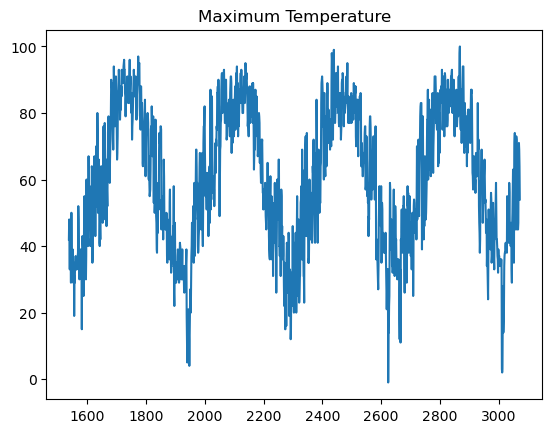

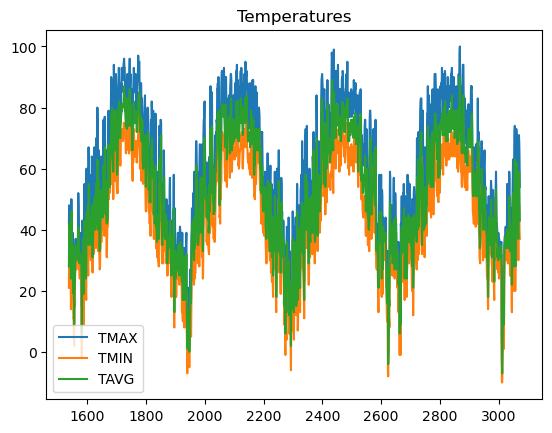

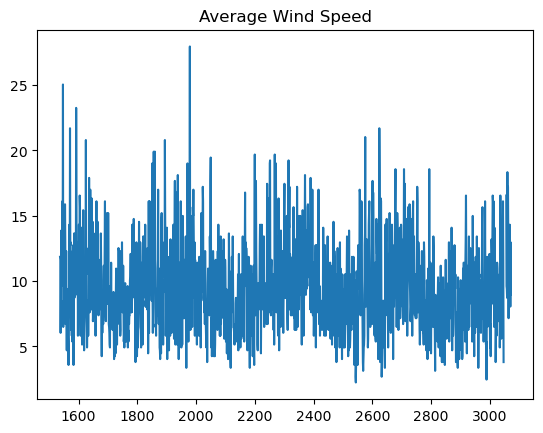

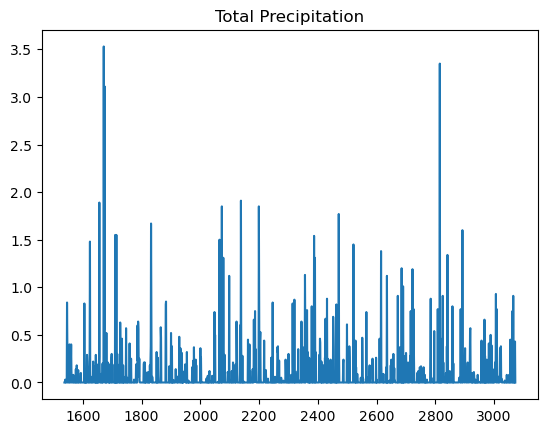

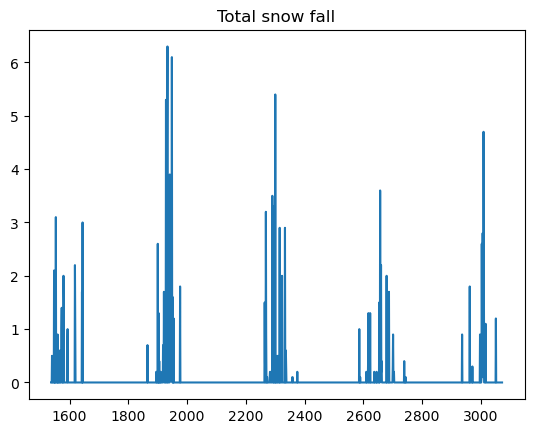

In [24]:
test = chicago_source3[['TMAX', 'TAVG', 'TMIN', 'AWND', 'PRCP', 'SNOW']].copy(deep=True)
test = test[:-1]
test['TMIN'] = pd.to_numeric(test['TMIN'], errors='coerce')
test['TMAX'] = pd.to_numeric(test['TMAX'], errors='coerce')
print('Average temperature:')
print(test['TAVG'].corr(test['TMAX']))
print('Minimum temperature:')
print(test['TMIN'].corr(test['TMAX']))
print('Average wind speed:')
print(test['AWND'].corr(test['TMAX']))
print('Total precipitation:')
print(test['PRCP'].corr(test['TMAX']))
print('Total snow fall:')
print(test['SNOW'].corr(test['TMAX']))

plt.plot(test['TMAX'])
plt.title('Maximum Temperature')
plt.show()

plt.plot(test.index, test['TMAX'], label='TMAX')
plt.plot(test.index, test['TMIN'], label='TMIN')
plt.plot(test.index, test['TAVG'], label='TAVG')

plt.title('Temperatures')
plt.legend()
plt.show()

plt.plot(test.index, test['AWND'], label='AWND')
plt.title('Average Wind Speed')
plt.show()
plt.plot(test.index, test['PRCP'], label='PRCP')
plt.title('Total Precipitation')
plt.show()
plt.plot(test.index, test['SNOW'], label='SNOW')
plt.title('Total snow fall')
plt.show()

From the previous correlation coefficients and graphs, many relations and patterns can already be identified. The correlation between Maximum temperature and average and minimum temperature is very strong, as expected, these features are clearly necessary for the model. From the plots of maximum temperature alone and then the three temperatures together, it is evident how they follow exactly the same pattern year to year. This shows that time series would be a good option for this model. Average wind speed has a weak but existent negative correlation with maximum temperature, which makes this a good feature to explore and something a fully connected neural network could identify. This feature also exhibits temporal patterns, as it has peaks similar to those of temperature, but sightly shifted. Still, this makes this data a good fit for time series models. Precipitation has the weakest correlation of all features. Thre is almost no correlation between precipitation and maximum temperature, but there are some temporal patterns that could be used to better identify patterns in other features, so it will still be used to train the model. Finally, total snow fall has a negative correlation, obviously, which is on the weaker side but still existent and relevant. This makes snow fall a good feature for a fully connected neural network and as expected, it follows temporal patterns which make it good for time series models. From all graphs it is also clear that this data is not linear, so a linear regression would be extremely inaccurate for this data, especially in extreme seasons such as summer and winter. In spring and fall a linear regression could show some accurate predictions but this would be misleading since this model would not be reusable or accurate overall. 

## Section 5: Model Version 1.0 - Ridge Regression

The different model options were explored using the scikit learn documentation, which provided detailed instructions on how to use each model and tool, as well as sample code that was very helpful for understanding. For the first version of the model, Ridge Regression was chosen due to its simplicity to implement and train, but its increased complexity relative to vanilla Linear Regression. To implement Ridge Regression, a MinMax Scaler was added for pre-procesing because the regularization term in Ridge Regression is sensitive to the scale of the features, and the features in this case have very different scales. When this model was being explored, only 2 sources were used for testing the model to make the process more efficient because organizing the data for training takes time and it was most lilely this model would not be the final version. The features used have very different scales, for example precipitation and surface pressure, so a Min Max Scaler is used to get positive values between 0 and 1 that maintain relationships between the data but put everything in the same scale. Min Max scaling doesn't handle outliers well, but that is not an issue in this case since outliers are extremely rare. The fitting process was scored using the built in function from sckikit learn's Ridge class, which returns the coefficient of determination for the model. This number was between 0.4 and 0.5 for most days in which this model was executed. These results were not terrible, and there was clearly no overfitting, but it was still a little low which was expected from a linear model.

### Imports

In [25]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

### Miami Source 2

For this source, 4 observations must be removed from the end of the dataframe. 3 because they are null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for Miami were: Maximum temperature, minimum temperature, average temperature, total precipitation, and average surface pressure for every day in the extracted range.

In [26]:
X = miami_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = miami_source2['DATE']
# Remove the 3 data points from the end of the data frame because they are null and 1 because it will be the prediction data point
X = X[:-4]  
fill_with_avg(X)  # Clean data using custom function

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_miami_source2 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = miami_source2[['LABEL']].copy(deep=True)
# Remove the same 4 data points removed from X 
y = y[:-4]

clf = Ridge(alpha=1.0)
clf.fit(scaled_miami_source2, y)
print("Score:")
print(clf.score(scaled_miami_source2, y))

# Make a prediction
X_predict = miami_source2[miami_source2['DATE'] == before_yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=[before_yesterday_encoded])

miami_source2_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(miami_source2_pred)

Score:
0.452454564396071
Prediction:
79.34461975097656


### Miami Source 5

For this source, 2 observations must be removed from the end of the dataframe. 1 because it is null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for Miami were: Maximum temperature, minimum temperature, average temperature, total precipitation, average wind speed, and average surface pressure for every day in the extracted range.

In [27]:
X = miami_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = miami_source5.index
# Remove only 2 data points from the end of the data frame
X = X[:-2]
fill_with_avg(X)  # Clean data using custom function

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_miami_source5 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = miami_source5[['LABEL']].copy(deep=True)
# Adjust labels to match dimensions of X
y = y[:-2]

clf = Ridge(alpha=1.0)
clf.fit(scaled_miami_source5, y)
print("Score:")
print(clf.score(scaled_miami_source5, y))

# Make a prediction
X_predict = miami_source5[miami_source5.index == yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=X_predict.index)
if(math.isnan(X_predict_scaled['WIND_SPEED'])):
    X_predict_scaled['WIND_SPEED'] = 0.0
if(math.isnan(X_predict_scaled['PRESSURE'])):
    X_predict_scaled['PRESSURE'] = 0.0

miami_source5_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(miami_source5_pred)

Score:
0.5507317573985744
Prediction:
85.16468777604688


### Chicago Source 2

For this source, 4 observations must be removed from the end of the dataframe. 3 because they are null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for Chicago were: Maximum temperature, minimum temperature, average temperature, total precipitation, and average surface pressure for every day in the extracted range.

In [28]:
X = chicago_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = chicago_source2['DATE']
# Remove 4 observations from the end of the input matrix
X = X[:-4]
fill_with_avg(X)  # Clean data using custom function

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_chicago_source2 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = chicago_source2[['LABEL']].copy(deep=True)
# Match the dimensions of X
y = y[:-4]

clf = Ridge(alpha=1.0)
clf.fit(scaled_chicago_source2, y)
print("Score:")
print(clf.score(scaled_chicago_source2, y))

# Make a prediction
X_predict = chicago_source2[chicago_source2['DATE'] == before_yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=[before_yesterday_encoded])

chicago_source2_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(chicago_source2_pred)

Score:
0.7250467720714361
Prediction:
48.85055160522461


### Chicago Source 5

For this source, 2 observations must be removed from the end of the dataframe. 1 because it is null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for Chicago were: Maximum temperature, minimum temperature, average temperature, total precipitation, total snow fall, average wind speed, and average surface pressure for every day in the extracted range.

In [29]:
X = chicago_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = chicago_source5.index
# Remove 2 observations from the end of the data frame
X = X[:-2]
fill_with_avg(X)  # Clean the data using custom function
# Custom cleaning because this feature often has NaN, and it is safe to assume 0
X['SNOW'].fillna(0.0, inplace=True)   

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_chicago_source5 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = chicago_source5[['LABEL']].copy(deep=True)
# Match dimensions of X
y = y[:-2]

clf = Ridge(alpha=1.0)
clf.fit(scaled_chicago_source5, y)
print("Score:")
print(clf.score(scaled_chicago_source5, y))

# Make a prediction
X_predict = chicago_source5[chicago_source5.index == yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW','WIND_SPEED', 'PRESSURE']]
X_predict['SNOW'].fillna(0.0, inplace=True)
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=X_predict.index)
if(math.isnan(X_predict_scaled['WIND_SPEED'])):
    X_predict_scaled['WIND_SPEED'] = 0.0
if(math.isnan(X_predict_scaled['PRESSURE'])):
    X_predict_scaled['PRESSURE'] = 0.0

chicago_source5_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(chicago_source5_pred)

Score:
0.7660853589072297
Prediction:
62.41483489968731


### New York Source 2

For this source, 4 observations must be removed from the end of the dataframe. 3 because they are null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for New York City are: Maximum temperature, minimum temperature, average temperature, total precipitation, and average surface pressure for every day in the extracted range.

In [30]:
X = ny_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = ny_source2['DATE']
# Remove 4 observations from the end of the data frame
X = X[:-4]
fill_with_avg(X)  # Clean data with custom function

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_ny_source2 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = ny_source2[['LABEL']].copy(deep=True)
# Match dimensions of X
y = y[:-4]

clf = Ridge(alpha=1.0)
clf.fit(scaled_ny_source2, y)
print("Score:")
print(clf.score(scaled_ny_source2, y))

# Make a prediction
X_predict = ny_source2[ny_source2['DATE'] == before_yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=[before_yesterday_encoded])

ny_source2_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(ny_source2_pred)

Score:
0.7262648818097617
Prediction:
52.856998443603516


### New York Source 5

For this source, 2 observations must be removed from the end of the dataframe. 1 because it is null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for New York City were: Maximum temperature, minimum temperature, average temperature, total precipitation, total snow fall, average wind speed, and average surface pressure for every day in the extracted range.

In [31]:
X = ny_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = ny_source5.index
# Remove 2 observations from the end of the data frame
X = X[:-2]
fill_with_avg(X)  # Clean data using custom function
# Custom cleaning because this feature often has many NaN together, it is safe to assume value 0
X['SNOW'].fillna(0.0, inplace=True)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_ny_source5 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = ny_source5[['LABEL']].copy(deep=True)
# Match dimensions of X
y = y[:-2]

clf = Ridge(alpha=1.0)
clf.fit(scaled_ny_source5, y)
print("Score:")
print(clf.score(scaled_ny_source5, y))

# Make a prediction
X_predict = ny_source5[ny_source5.index == yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW','WIND_SPEED', 'PRESSURE']]
X_predict['SNOW'].fillna(0.0, inplace=True)
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=X_predict.index)

ny_source5_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(ny_source5_pred)

Score:
0.7307063995577249
Prediction:
51.5450554007921


### Austin Source 2

For this source, 4 observations must be removed from the end of the dataframe. 3 because they are null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for Austin are: Maximum temperature, minimum temperature, average temperature, total precipitation, and average surface pressure for every day in the extracted range.

In [32]:
X = austin_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = austin_source2['DATE']
# Remove 4 observations from the end of the data frame
X = X[:-4]
fill_with_avg(X)  # Clean data with custom function

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values, ignoring the index
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_austin_source2 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = austin_source2[['LABEL']].copy(deep=True)
# Match dimensions of X
y = y[:-4]

clf = Ridge(alpha=1.0)
clf.fit(scaled_austin_source2, y)
print("Score:")
print(clf.score(scaled_austin_source2, y))

# Make a prediction
X_predict = austin_source2[austin_source2['DATE'] == before_yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=[before_yesterday_encoded])

austin_source2_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(austin_source2_pred)

Score:
0.6805707499420457
Prediction:
76.28665161132812


### Austin Source 5

For this source, 2 observations must be removed from the end of the dataframe. 1 because it is null, and 1 because it will be used for prediction. The same is done to the labels so the dimensions match for training. Not all of the features from the source are used because some of them don't provide any information such as the name of the station. The features used in this source for Austin are: Maximum temperature, minimum temperature, average temperature, total precipitation, average wind speed, and average surface pressure for every day in the extracted range.

In [33]:
X = austin_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = austin_source5.index
# Remove 2 observations from the end of the data frame
X = X[:-2]
fill_with_avg(X)  # Clean data using custom function

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the dataframe values, ignoring the index
scaler.fit(X)
scaled_values = scaler.transform(X)

# Create a new DataFrame with the scaled values and the original index
scaled_austin_source5 = pd.DataFrame(scaled_values, columns=X.columns, index=X.index)

y = austin_source5[['LABEL']].copy(deep=True)
# Match dimensions of X
y = y[:-2]

clf = Ridge(alpha=1.0)
clf.fit(scaled_austin_source5, y)
print("Score:")
print(clf.score(scaled_austin_source5, y))

# Make a prediction
X_predict = austin_source5[austin_source5.index == yesterday_encoded]
X_predict = X_predict[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_predict)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_predict.columns, index=X_predict.index)

austin_source5_pred = clf.predict(X_predict_scaled).item()
print("Prediction:")
print(austin_source5_pred)

Score:
0.702823490015557
Prediction:
78.72255600668012


### Predictions

A summary of the predictions is shown here for testing purposes. Using the Min Max Scaler got the predictions to an acceptable range, but they were often outside the range given in the Kalshi platform, and often over 7 degrees away from Accuweather's prediction, which was the most frquent reference used for validation. More on predictions and scoring in Section 8: Model Evaluation.

In [34]:
print("Miami predictions:")
print(f"Source 2: {miami_source2_pred}")
print(f"Source 5: {miami_source5_pred}")

print("Chicago predictions:")
print(f"Source 2: {chicago_source2_pred}")
print(f"Source 5: {chicago_source5_pred}")

print("New York predictions:")
print(f"Source 2: {ny_source2_pred}")
print(f"Source 5: {ny_source5_pred}")

print("Austin predictions:")
print(f"Source 2: {austin_source2_pred}")
print(f"Source 5: {austin_source5_pred}")

Miami predictions:
Source 2: 79.34461975097656
Source 5: 85.16468777604688
Chicago predictions:
Source 2: 48.85055160522461
Source 5: 62.41483489968731
New York predictions:
Source 2: 52.856998443603516
Source 5: 51.5450554007921
Austin predictions:
Source 2: 76.28665161132812
Source 5: 78.72255600668012


## Section 6: Model Version 2.0 - MLP Regressor

For the second version of the model, the target of the exploration phase was neural networks. After reading the course textbooks, different articles online, and the scikit learn documentation and recommendations, Multi-Layer Perceptron Regressors were the best option for this task. MLP Regressors have multiple settings to adjust, and they can be combined with lots of pre-processing methods; this flexibility was perfect to improve predictions through educated trial and error. For data pre-processing, the most important issue to resolve was the scaling of the features, because these differences in scale are likely sources of model divergence. During this phase, two scaling techniques were tested side-by-side: MinMax Scaling and Standard Scaling. Both algorithms behaved pretty similarly, and they both have similar pros and cons, but the empirical observations showed that Standard Scaling tends to increase the prediction by 1 or 2 degrees relative to MinMax Scaling, and due to possible inconsistencies with the data, it was beneficial for accuracy for the prediction to be as low as possible, so MinMax Scaling was chosen for the final model. For this stage, only 3 sources were used for each city to optimize time and focus on evaluating MLP Regressors and choosing a scaling method. Source 2 and 5 were processed in the same way as for Ridge Regression, with the exception of making two predictions per source, per city, using Standard Scaler for one and MinMax Scaler for the other. The MLPRegressor was set up almost identically for all predictions: All of them have 2 hidden layers, the first one with 100 neurons and the second one with 6 neurons. There was few trial and error done to the structure of the neural network, since the changes made had little effect on the predictions. The number of epochs was initially set to 500 for all Regressors, but they had to be increased to 1000 because most networks weren't able to converge with 500 epochs. There is one exception that required 1500 epochs because it wasn't converging with 1000 epochs. The activation function was always set to ReLU for all networks, all readings recommended using this function for regression purposes and its nonlinearity was key for predicting this data. Only one other activation function was tested and it changed the results drastically, so instead of re-tuning the network, ReLU was chosen since it was the most recommended function anyway. The solver for the MLP Regressors was adam, because it seemed the most appropriate for this task according to the scikit learn documentation. It is a variation of gradient descent and it aids faster convergence. The random_state was never changed, it was left as the scikit learn documentation recommended, and the learning rate was adjusted between 0.0001 and 0.01, but the final decision was to use a learning rate of 0.001 because it gave decent convergence time and very good predictions.

### Imports

In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Miami Source 2

#### Standard Scaler

In [36]:
X = miami_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = miami_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_miami_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = miami_source2[miami_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = miami_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [37]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_miami_source2, y)
pred_mia_2_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_mia_2_ss)

Prediction:
[78.25359]


#### MinMax Scaler

In [38]:
X = miami_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = miami_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_miami_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = miami_source2[miami_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = miami_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [39]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_miami_source2, y)
pred_mia_2_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_mia_2_mm)

Prediction:
[78.09904]


### Miami Source 3

#### Standard Scaler

In [40]:
X = miami_source3[['TMAX', 'TMIN', 'TAVG', 'PRCP', 'AWND']].copy(deep=True)
X.index = miami_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_miami_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_miami_source3.fillna(0, inplace=True)

X_test = miami_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y = miami_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [41]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_miami_source3, y)
pred_mia_3_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_mia_3_ss)

Prediction:
[80.9994944]


#### MinMax Scaler

In [42]:
X = miami_source3[['TMAX', 'TMIN', 'TAVG', 'PRCP', 'AWND']].copy(deep=True)
X.index = miami_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_miami_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_miami_source3.fillna(0, inplace=True)

X_test = miami_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y = miami_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [43]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_miami_source3, y)
pred_mia_3_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_mia_3_mm)

Prediction:
[81.43093615]


### Miami Source 5

#### Standard Scaler

In [44]:
X = miami_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = miami_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_miami_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = miami_source5[miami_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)

y = miami_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [45]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_miami_source5, y)
pred_mia_5_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_mia_5_ss)

Prediction:
[83.8957257]


#### MinMax Scaler

In [46]:
X = miami_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = miami_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_miami_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = miami_source5[miami_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)

y = miami_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [47]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_miami_source5, y)
pred_mia_5_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_mia_5_mm)

Prediction:
[84.25087399]


### New York Source 2

#### Standard Scaler

In [48]:
X = ny_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']].copy(deep=True)
X.index = ny_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_ny_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = ny_source2[ny_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = ny_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [49]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_ny_source2, y)
pred_nyc_2_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_nyc_2_ss)

Prediction:
[53.22766]


#### MinMax Scaler

In [50]:
X = ny_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']].copy(deep=True)
X.index = ny_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_ny_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = ny_source2[ny_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = ny_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [51]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_ny_source2, y)
pred_nyc_2_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_nyc_2_mm)

Prediction:
[52.54103]


### New York Source 3

#### Standard Scaler

In [56]:
X = ny_source3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']].copy(deep=True)
X.index = ny_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_ny_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_ny_source3.fillna(0, inplace=True)

X_test = ny_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0.0, inplace=True)

y = ny_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [57]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_ny_source3, y)
pred_nyc_3_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_nyc_3_ss)

Prediction:
[59.41093563]


#### MinMax Scaler

In [60]:
X = ny_source3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']].copy(deep=True)
X.index = ny_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_ny_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_ny_source3.fillna(0, inplace=True)

X_test = ny_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0.0, inplace=True)

y = ny_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [61]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_ny_source3, y)
pred_nyc_3_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_nyc_3_mm)

Prediction:
[60.4079473]


### New York Source 5

#### Standard Scaler

In [62]:
X = ny_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = ny_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_ny_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_ny_source5.fillna(0, inplace=True)

X_test = ny_source5[ny_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0, inplace=True)

y = ny_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [63]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_ny_source5, y)
pred_nyc_5_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_nyc_5_ss)

Prediction:
[52.47620713]


#### MinMax Scaler

In [64]:
X = ny_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = ny_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_ny_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_ny_source5.fillna(0, inplace=True)

X_test = ny_source5[ny_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0, inplace=True)

y = ny_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [65]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_ny_source5, y)
pred_nyc_5_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_nyc_5_mm)

Prediction:
[52.84683493]


### Chicago Source 2

#### Standard Scaler

In [66]:
X = chicago_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']].copy(deep=True)
X.index = chicago_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_chicago_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = chicago_source2[chicago_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = chicago_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [67]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_chicago_source2, y)
pred_chi_2_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_chi_2_ss)

Prediction:
[47.45319]


#### MinMax Scaler

In [68]:
X = chicago_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']].copy(deep=True)
X.index = chicago_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_chicago_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = chicago_source2[chicago_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = chicago_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [69]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_chicago_source2, y)
pred_chi_2_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_chi_2_mm)

Prediction:
[48.766212]


### Chicago Source 3

#### Standard Scaler

In [70]:
X = chicago_source3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']].copy(deep=True)
X.index = chicago_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_chicago_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_chicago_source3.fillna(0, inplace=True)

X_test = chicago_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y = chicago_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [71]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_chicago_source3, y)
pred_chi_3_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_chi_3_ss)

Prediction:
[43.53379578]


#### MinMax Scaler

In [72]:
X = chicago_source3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']].copy(deep=True)
X.index = chicago_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_chicago_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_chicago_source3.fillna(0, inplace=True)

X_test = chicago_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y = chicago_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [73]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_chicago_source3, y)
pred_chi_3_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_chi_3_mm)

Prediction:
[42.34775498]


### Chicago Source 5

#### Standard Scaler

In [74]:
X = chicago_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = chicago_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_chicago_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_chicago_source5.fillna(0, inplace=True)

X_test = chicago_source5[chicago_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0, inplace=True)

y = chicago_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [75]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_chicago_source5, y)
pred_chi_5_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_chi_5_ss)

Prediction:
[58.6920941]


#### MinMax Scaler

In [76]:
X = chicago_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = chicago_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_chicago_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_chicago_source5.fillna(0, inplace=True)

X_test = chicago_source5[chicago_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0, inplace=True)

y = chicago_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [77]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_chicago_source5, y)
pred_chi_5_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_chi_5_mm)

Prediction:
[62.80279638]


### Austin Source 2

#### Standard Scaler

In [78]:
X = austin_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = austin_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_austin_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = austin_source2[austin_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = austin_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [79]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_austin_source2, y)
pred_aus_2_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_aus_2_ss)

Prediction:
[73.749405]


#### MinMax Scaler

In [80]:
X = austin_source2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X.index = austin_source2['DATE']
X = X[:-4]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_austin_source2 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)

X_test = austin_source2[austin_source2['DATE'] == before_yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=[before_yesterday_encoded])

y = austin_source2[['LABEL']].copy(deep=True)
y = y[:-4]
y = y['LABEL'].ravel()

In [81]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_austin_source2, y)
pred_aus_2_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_aus_2_mm)

Prediction:
[74.642975]


### Austin Source 3

#### Standard Scaler

In [86]:
X = austin_source3[['TMAX', 'TMIN', 'PRCP', 'AWND']].copy(deep=True)
X.index = austin_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_austin_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_austin_source3.fillna(0, inplace=True)

X_test = austin_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y = austin_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [87]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_austin_source3, y)
pred_aus_3_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_aus_3_ss)

Prediction:
[73.87839441]


#### MinMax Scaler

In [88]:
X = austin_source3[['TMAX', 'TMIN', 'PRCP', 'AWND']].copy(deep=True)
X.index = austin_source3['DATE']
X = X[:source_3_constant - 1]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_austin_source3 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_austin_source3.fillna(0, inplace=True)

X_test = austin_source3.iloc[source_3_constant:source_3_constant+1]
X_test.index = X_test['DATE']
X_test = X_test[['TMAX', 'TMIN', 'PRCP', 'AWND']]
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

y = austin_source3[['LABEL']].copy(deep=True)
y = y[:source_3_constant - 1]
y = y['LABEL'].ravel()

In [89]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1500, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_austin_source3, y)
pred_aus_3_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_aus_3_mm)

Prediction:
[75.93065741]


### Austin Source 5

#### Standard Scaler

In [90]:
X = austin_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = austin_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_austin_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_austin_source5.fillna(0, inplace=True)

X_test = austin_source5[austin_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0, inplace=True)

y = austin_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [91]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_austin_source5, y)
pred_aus_5_ss = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_aus_5_ss)

Prediction:
[72.99173197]


#### MinMax Scaler

In [92]:
X = austin_source5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X.index = austin_source5.index
X = X[:-2]
fill_with_avg(X)

scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X)
scaled_austin_source5 = pd.DataFrame(X_train_scaled, columns=X.columns, index=X.index)
scaled_austin_source5.fillna(0, inplace=True)

X_test = austin_source5[austin_source5.index == yesterday_encoded]
X_test = X_test[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'WIND_SPEED', 'PRESSURE']]
scaled_value = scaler.transform(X_test)
X_predict_scaled = pd.DataFrame(scaled_value, columns=X_test.columns, index=X_test.index)
X_predict_scaled.fillna(0, inplace=True)

y = austin_source5[['LABEL']].copy(deep=True)
y = y[:-2]
y = y['LABEL'].ravel()

In [93]:
mlp = MLPRegressor(hidden_layer_sizes=(100,6), max_iter=1000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)

mlp.fit(scaled_austin_source5, y)
pred_aus_5_mm = mlp.predict(X_predict_scaled)

print("Prediction:")
print(pred_aus_5_mm)

Prediction:
[78.83868337]


### Predictions

In order to compare all predictions, especially those for the same source and city but with different scaling method, all predictions were printed here for analysis. Variable names ending in 'ss' indicate Standard Scaler, and those ending in 'mm' indicate MinMax Scaler. As mentioned before, Standard scaling gave slightly higher predictions than MinMax scaling most of the time, so the MinMax Scaler was chosen for the final model, since lower predictions were more accurate due to the nature of the sources. For this model, the final prediction submitted to Kalshi was calculated by averaging all of these predictions for each city, but this changed for the final model since the Standard Scaler was no longer used.

In [94]:
print(f'pred_mia_2_ss: {pred_mia_2_ss}')
print(f'pred_mia_2_mm: {pred_mia_2_mm}')

print(f'pred_mia_3_ss: {pred_mia_3_ss}')
print(f'pred_mia_3_mm: {pred_mia_3_mm}')

print(f'pred_mia_5_ss: {pred_mia_5_ss}')
print(f'pred_mia_5_mm: {pred_mia_5_mm}')

print(f'pred_nyc_2_ss: {pred_nyc_2_ss}')
print(f'pred_nyc_2_mm: {pred_nyc_2_mm}')

print(f'pred_nyc_3_ss: {pred_nyc_3_ss}')
print(f'pred_nyc_3_mm: {pred_nyc_3_mm}')

print(f'pred_nyc_5_ss: {pred_nyc_5_ss}')
print(f'pred_nyc_5_mm: {pred_nyc_5_mm}')

print(f'pred_chi_2_ss: {pred_chi_2_ss}')
print(f'pred_chi_2_mm: {pred_chi_2_mm}')

print(f'pred_chi_3_ss: {pred_chi_3_ss}')
print(f'pred_chi_3_mm: {pred_chi_3_mm}')

print(f'pred_chi_5_ss: {pred_chi_5_ss}')
print(f'pred_chi_5_mm: {pred_chi_5_mm}')

print(f'pred_aus_2_ss: {pred_aus_2_ss}')
print(f'pred_aus_2_mm: {pred_aus_2_mm}')

print(f'pred_aus_3_ss: {pred_aus_3_ss}')
print(f'pred_aus_3_mm: {pred_aus_3_mm}')

print(f'pred_aus_5_ss: {pred_aus_5_ss}')
print(f'pred_aus_5_mm: {pred_aus_5_mm}')

pred_mia_2_ss: [78.25359]
pred_mia_2_mm: [78.09904]
pred_mia_3_ss: [80.9994944]
pred_mia_3_mm: [81.43093615]
pred_mia_5_ss: [83.8957257]
pred_mia_5_mm: [84.25087399]
pred_nyc_2_ss: [53.22766]
pred_nyc_2_mm: [52.54103]
pred_nyc_3_ss: [59.41093563]
pred_nyc_3_mm: [60.4079473]
pred_nyc_5_ss: [52.47620713]
pred_nyc_5_mm: [52.84683493]
pred_chi_2_ss: [47.45319]
pred_chi_2_mm: [48.766212]
pred_chi_3_ss: [43.53379578]
pred_chi_3_mm: [42.34775498]
pred_chi_5_ss: [58.6920941]
pred_chi_5_mm: [62.80279638]
pred_aus_2_ss: [73.749405]
pred_aus_2_mm: [74.642975]
pred_aus_3_ss: [73.87839441]
pred_aus_3_mm: [75.93065741]
pred_aus_5_ss: [72.99173197]
pred_aus_5_mm: [78.83868337]


## Section 7: Final Model

For the final model, the MLP Regressor model was kept, with slight changes. Additionally, major changes were made to the structure of the model for efficiency and improved readability. The use of scikit learn Pipelines was introduced for the final model, making it more efficient to instantiate the 5 regressors used for each city, and connect them automatically to the scaling algorithm. There was an attempt to add a fusion layer at the beginning of the network so only one model had to be built per city, but this proved to be extremely complex for this case because the sources have different numbers of observations. Instead of the fusion layer, pipelines were introduced so the process would be simpler but still building 1 model per source per city, they are all identical models. The process to make a prediction in this final model is organizing the data for sources 2, 3 and 5 the same way as they have been organized and cleaned before. For sources 1 and 4, the process is very similar, but adjusted to the features and needs of these sources. After the data is all organized into variables with simple names, input data, labels, and testing data for each source are organized in ordered collections. Then, one pipeline is created for each source using a loop, each pipeline is identical and consists of a MinMax Scaler and an MLP Regressor, all pipelines are saved in an ordered collection as well. Then, using another loop, the algorithm iterates simultaneously over the input data collection, the labels collection, the testing data collection, and the pipeline collection. On each iteration of the loop, it chooses the pipeline and its corresponding input, label and testing data, and then fits the pipeline with the input data and labels, and then predicts using the testing data and the trained model, saving the prediction in a predictions collection. Finally, a final prediction for the city is saved by averaging the predictions collection holding the prediction for each source. The MLP Regressor in each pipeline is identical to those in all pipelines, and they are almost identical to the ones used in Section 6: Model Version 2.0 - MLP Regressor. The only exceptions are: the MLP Regressors used here have 2 hidden layers, the first one has 100 neurons, and the second one has 31 neurons. Through trial and error, this structure gave the best predictions, but the changes were very slight anyway. Additionally, the number of epochs had to be increased to 3000 because most models were no longing converging with 1000 epochs.

### Imports

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np

### Miami

In [96]:
source_1 = miami_source1.copy(deep=True)
source_2 = miami_source2.copy(deep=True)
source_3 = miami_source3.copy(deep=True)
source_4 = miami_source4.copy(deep=True)
source_5 = miami_source5.copy(deep=True)

#### Source 1

In [97]:
X_train_1 = source_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']].copy(deep=True)
X_train_1.index = source_1.index
X_train_1 = X_train_1[:-2]

X_test_1 = source_1[source_1.index == yesterday_encoded]
X_test_1 = X_test_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']]

y_1 = source_1[['label']].copy(deep=True)
y_1 = y_1[:-2]
y_1 = y_1['label'].ravel()

#### Source 2

In [98]:
X_train_2 = source_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X_train_2.index = source_2['DATE']
X_train_2 = X_train_2[:-4]
fill_with_avg(X_train_2)

X_test_2 = source_2[source_2['DATE'] == before_yesterday_encoded]
X_test_2 = X_test_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]

y_2 = source_2[['LABEL']].copy(deep=True)
y_2 = y_2[:-4]
y_2 = y_2['LABEL'].ravel()

#### Source 3

In [99]:
X_train_3 = source_3[['TMAX', 'TMIN', 'TAVG', 'PRCP', 'AWND']].copy(deep=True)
X_train_3.index = source_3['DATE']
X_train_3 = X_train_3[:source_3_constant - 1]
fill_with_avg(X_train_3)
X_train_3.fillna(0, inplace=True)

X_test_3 = source_3.iloc[source_3_constant:source_3_constant+1]
X_test_3.index = X_test_3['DATE']
X_test_3 = X_test_3[['TMAX', 'TMIN', 'TAVG', 'PRCP', 'AWND']]

y_3 = source_3[['LABEL']].copy(deep=True)
y_3 = y_3[:source_3_constant - 1]
y_3 = y_3['LABEL'].ravel()

#### Source 4

In [100]:
X_train_4 = source_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'humidity']].copy(deep=True)
X_train_4.index = source_4.index
X_train_4 = X_train_4[:-2]

X_test_4 = source_4[source_4.index == yesterday_encoded]
X_test_4 = X_test_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'humidity']]

y_4 = source_4[['label']].copy(deep=True)
y_4 = y_4[:-2]
y_4 = y_4['label'].ravel()

#### Source 5

In [101]:
X_train_5 = source_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']].copy(deep=True)
X_train_5.index = source_5.index
X_train_5 = X_train_5[:-2]
fill_with_avg(X_train_5)

X_test_5 = source_5[source_5.index == yesterday_encoded]
X_test_5 = X_test_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION','WIND_SPEED', 'PRESSURE']]

y_5 = source_5[['LABEL']].copy(deep=True)
y_5 = y_5[:-2]
y_5 = y_5['LABEL'].ravel()

#### Model

In [102]:
X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]  # Training data array
X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]  # Testing data array
y = [y_1, y_2, y_3, y_4, y_5]  # Labels array
pipelines = []  # Pipelines array
predictions = np.array([])

for i in range(5):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('mlp', MLPRegressor(hidden_layer_sizes=(100,31), max_iter=3000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001))  
    ])
    pipelines.append(pipeline)   # Fill pipelines arra
    
# Use all pipelines with their corresponding data sources
for i in range(5): 
    pipelines[i].fit(X_train[i], y[i])
    predictions = np.append(predictions, pipelines[i].predict(X_test[i]))
    
miami_pred = np.mean(predictions)
print("Prediction:")
print(miami_pred)

Prediction:
89.38382985416425


### New York

In [103]:
source_1 = ny_source1.copy(deep=True)
source_2 = ny_source2.copy(deep=True)
source_3 = ny_source3.copy(deep=True)
source_4 = ny_source4.copy(deep=True)
source_5 = ny_source5.copy(deep=True)

#### Source 1

In [104]:
X_train_1 = source_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']].copy(deep=True)
X_train_1.index = source_1.index
X_train_1 = X_train_1[:-2]

X_test_1 = source_1[source_1.index == yesterday_encoded]
X_test_1 = X_test_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']]

y_1 = source_1[['label']].copy(deep=True)
y_1 = y_1[:-2]
y_1 = y_1['label'].ravel()

#### Source 2

In [105]:
X_train_2 = source_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']].copy(deep=True)
X_train_2.index = source_2['DATE']
X_train_2 = X_train_2[:-4]
fill_with_avg(X_train_2)

X_test_2 = source_2[source_2['DATE'] == before_yesterday_encoded]
X_test_2 = X_test_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']]

y_2 = source_2[['LABEL']].copy(deep=True)
y_2 = y_2[:-4]
y_2 = y_2['LABEL'].ravel()

#### Source 3

In [110]:
X_train_3 = source_3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']].copy(deep=True)
X_train_3.index = source_3['DATE']
X_train_3 = X_train_3[:source_3_constant - 1]
fill_with_avg(X_train_3)
X_train_3.fillna(0, inplace=True)

X_test_3 = source_3.iloc[source_3_constant:source_3_constant+1]
X_test_3.index = X_test_3['DATE']
X_test_3 = X_test_3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']]
X_test_3.fillna(0, inplace=True)

y_3 = source_3[['LABEL']].copy(deep=True)
y_3 = y_3[:source_3_constant - 1]
y_3 = y_3['LABEL'].ravel()

#### Source 4

In [111]:
X_train_4 = source_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'snow', 'humidity']].copy(deep=True)
X_train_4.index = source_4.index
X_train_4 = X_train_4[:-2]

X_test_4 = source_4[source_4.index == yesterday_encoded]
X_test_4 = X_test_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'snow', 'humidity']]

y_4 = source_4[['label']].copy(deep=True)
y_4 = y_4[:-2]
y_4 = y_4['label'].ravel()

#### Source 5

In [112]:
X_train_5 = source_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X_train_5.index = source_5.index
X_train_5 = X_train_5[:-2]
fill_with_avg(X_train_5)
X_train_5.fillna(0, inplace=True)

X_test_5 = source_5[source_5.index == yesterday_encoded]
X_test_5 = X_test_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']]
X_test_5.fillna(0, inplace=True)

y_5 = source_5[['LABEL']].copy(deep=True)
y_5 = y_5[:-2]
y_5 = y_5['LABEL'].ravel()

#### Model

In [113]:
X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]  # Training data array
X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]   # Testing data array
y = [y_1, y_2, y_3, y_4, y_5]  # Labels arra
pipelines = []  # Pipelines array
predictions = np.array([])

for i in range(5):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('mlp', MLPRegressor(hidden_layer_sizes=(100,31), max_iter=3000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001))  
    ])
    pipelines.append(pipeline)  # Fill pipelines array

# Use all pipelines with their corresponding data sources
for i in range(5):
    pipelines[i].fit(X_train[i], y[i])
    predictions = np.append(predictions, pipelines[i].predict(X_test[i]))
    
ny_pred = np.mean(predictions)
print("Prediction:")
print(ny_pred)

Prediction:
48.52383991186423


### Chicago

In [114]:
source_1 = chicago_source1.copy(deep=True)
source_2 = chicago_source2.copy(deep=True)
source_3 = chicago_source3.copy(deep=True)
source_4 = chicago_source4.copy(deep=True)
source_5 = chicago_source5.copy(deep=True)

#### Source 1

In [115]:
X_train_1 = source_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']].copy(deep=True)
X_train_1.index = source_1.index
X_train_1 = X_train_1[:-2]

X_test_1 = source_1[source_1.index == yesterday_encoded]
X_test_1 = X_test_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']]

y_1 = source_1[['label']].copy(deep=True)
y_1 = y_1[:-2]
y_1 = y_1['label'].ravel()

#### Source 2

In [116]:
X_train_2 = source_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']].copy(deep=True)
X_train_2.index = source_2['DATE']
X_train_2 = X_train_2[:-4]
fill_with_avg(X_train_2)

X_test_2 = source_2[source_2['DATE'] == before_yesterday_encoded]
X_test_2 = X_test_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'surface_pressure']]

y_2 = source_2[['LABEL']].copy(deep=True)
y_2 = y_2[:-4]
y_2 = y_2['LABEL'].ravel()

#### Source 3

In [117]:
X_train_3 = source_3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']].copy(deep=True)
X_train_3.index = source_3['DATE']
X_train_3 = X_train_3[:source_3_constant - 1]
fill_with_avg(X_train_3)
X_train_3.fillna(0, inplace=True)

X_test_3 = source_3.iloc[source_3_constant:source_3_constant+1]
X_test_3.index = X_test_3['DATE']
X_test_3 = X_test_3[['TMAX', 'TMIN', 'SNOW', 'PRCP', 'AWND']]

y_3 = source_3[['LABEL']].copy(deep=True)
y_3 = y_3[:source_3_constant - 1]
y_3 = y_3['LABEL'].ravel()

#### Source 4

In [118]:
X_train_4 = source_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'snow', 'humidity']].copy(deep=True)
X_train_4.index = source_4.index
X_train_4 = X_train_4[:-2]

X_test_4 = source_4[source_4.index == yesterday_encoded]
X_test_4 = X_test_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'snow', 'humidity']]

y_4 = source_4[['label']].copy(deep=True)
y_4 = y_4[:-2]
y_4 = y_4['label'].ravel()

#### Source 5

In [119]:
X_train_5 = source_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X_train_5.index = source_5.index
X_train_5 = X_train_5[:-2]
fill_with_avg(X_train_5)
X_train_5.fillna(0, inplace=True)

X_test_5 = source_5[source_5.index == yesterday_encoded]
X_test_5 = X_test_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'SNOW', 'WIND_SPEED', 'PRESSURE']]
X_test_5.fillna(0, inplace=True)

y_5 = source_5[['LABEL']].copy(deep=True)
y_5 = y_5[:-2]
y_5 = y_5['LABEL'].ravel()

#### Model

In [120]:
X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]  # Training data array
X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]  # Testing data array
y = [y_1, y_2, y_3, y_4, y_5]  # Labels array
pipelines = []  # Pipelines array
predictions = np.array([])

for i in range(5):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('mlp', MLPRegressor(hidden_layer_sizes=(100,31), max_iter=3000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001))  
    ])
    pipelines.append(pipeline)  # Fill pipelines array

# Use all pipelines with their corresponding data sources
for i in range(5):
    pipelines[i].fit(X_train[i], y[i])
    predictions = np.append(predictions, pipelines[i].predict(X_test[i]))
    
chicago_pred = np.mean(predictions)
print("Prediction:")
print(chicago_pred)

Prediction:
52.77761207357023


### Austin

In [121]:
source_1 = austin_source1.copy(deep=True)
source_2 = austin_source2.copy(deep=True)
source_3 = austin_source3.copy(deep=True)
source_4 = austin_source4.copy(deep=True)
source_5 = austin_source5.copy(deep=True)

#### Source 1

In [122]:
X_train_1 = source_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']].copy(deep=True)
X_train_1.index = source_1.index
X_train_1 = X_train_1[:-2]

X_test_1 = source_1[source_1.index == yesterday_encoded]
X_test_1 = X_test_1[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed']]

y_1 = source_1[['label']].copy(deep=True)
y_1 = y_1[:-2]
y_1 = y_1['label'].ravel()

#### Source 2

In [123]:
X_train_2 = source_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']].copy(deep=True)
X_train_2.index = source_2['DATE']
X_train_2 = X_train_2[:-4]
fill_with_avg(X_train_2)

X_test_2 = source_2[source_2['DATE'] == before_yesterday_encoded]
X_test_2 = X_test_2[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'surface_pressure']]

y_2 = source_2[['LABEL']].copy(deep=True)
y_2 = y_2[:-4]
y_2 = y_2['LABEL'].ravel()

#### Source 3

In [125]:
X_train_3 = source_3[['TMAX', 'TMIN', 'PRCP', 'AWND']].copy(deep=True)
X_train_3.index = source_3['DATE']
X_train_3 = X_train_3[:source_3_constant - 1]
fill_with_avg(X_train_3)
X_train_3.fillna(0, inplace=True)

X_test_3 = source_3.iloc[source_3_constant:source_3_constant+1]
X_test_3.index = X_test_3['DATE']
X_test_3 = X_test_3[['TMAX', 'TMIN', 'PRCP', 'AWND']]

y_3 = source_3[['LABEL']].copy(deep=True)
y_3 = y_3[:source_3_constant - 1]
y_3 = y_3['LABEL'].ravel()

#### Source 4

In [126]:
X_train_4 = source_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'humidity']].copy(deep=True)
X_train_4.index = source_4.index
X_train_4 = X_train_4[:-2]

X_test_4 = source_4[source_4.index == yesterday_encoded]
X_test_4 = X_test_4[['max_temperature', 'min_temperature', 'average_temperature', 'average_pressure', 'total_precipitation', 'average_wind_speed', 'humidity']]

y_4 = source_4[['label']].copy(deep=True)
y_4 = y_4[:-2]
y_4 = y_4['label'].ravel()

#### Source 5

In [127]:
X_train_5 = source_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'WIND_SPEED', 'PRESSURE']].copy(deep=True)
X_train_5.index = source_5.index
X_train_5 = X_train_5[:-2]
fill_with_avg(X_train_5)
X_train_5.fillna(0, inplace=True)

X_test_5 = source_5[austin_source5.index == yesterday_encoded]
X_test_5 = X_test_5[['TMAX', 'TMIN', 'TAVG', 'PRECIPITATION', 'WIND_SPEED', 'PRESSURE']]
X_test_5.fillna(0, inplace=True)

y_5 = source_5[['LABEL']].copy(deep=True)
y_5 = y_5[:-2]
y_5 = y_5['LABEL'].ravel()

#### Model

In [128]:
X_train = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5] # Training data array
X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5] # Testing data array
y = [y_1, y_2, y_3, y_4, y_5] # Labels array
pipelines = []  # Pipelines array
predictions = np.array([])

for i in range(5):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('mlp', MLPRegressor(hidden_layer_sizes=(100,31), max_iter=3000, activation='relu', 
                   solver='adam', random_state=42, learning_rate_init=0.001)) 
    ])
    pipelines.append(pipeline)  # Fill pipelines array

# Use all pipelines with their corresponding data sources
for i in range(5):
    pipelines[i].fit(X_train[i], y[i])
    predictions = np.append(predictions, pipelines[i].predict(X_test[i]))
    
austin_pred = np.mean(predictions)
print("Prediction:")
print(austin_pred)

Prediction:
76.29131145910945


### Predictions

The final prediction for each city is displayed here for easy viewing, these are ready to submit to Kalshi.

In [129]:
print(f"Miami: {miami_pred}")
print(f"New York: {ny_pred}")
print(f"Chicago: {chicago_pred}")
print(f"Austin: {austin_pred}")

Miami: 89.38382985416425
New York: 48.52383991186423
Chicago: 52.77761207357023
Austin: 76.29131145910945


## Section 8: Model Evaluation

To evaluate the accuracy of the model and the model overall, three metrics are used: Mean Squared Error (MSE), Mean Absolute Error (MAE), and Coefficient of Determination (R^2). MAE will give a precise measure of the error the model's predictions have had, which can be used to estimate the error the model will have in the future. MSE will give a similar result, but penalizing really large errors, so it is more evident when the model makes big mistakes in the predictions and when it makes small mistakes which are acceptable in this case. Finally, R^2 evaluates the fit of the model's predictions with the real values, and the extent to which the independent variables explain the variance of the dependent variable, which is also an excellent metric to evaluate the model's performance, since the other 2 metrics used can be misleading, which will be explained later in the report. For this model evaluation, the prediction values used were those given by the midpoint of the range of the option purchased each day on Kalshi, or in the case of extrema options (T and above or T and below), by the edge value T. The true values for each prediction day were extracted from the winning option in Kalshi for that day in the same way, midpoint of option range or limit value for extrema options (T and above or T and below). The model will be analyzed as a whole first, and then city by city because different patterns and metrics can be generated from each of these analysis.

### Imports

In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Full Model

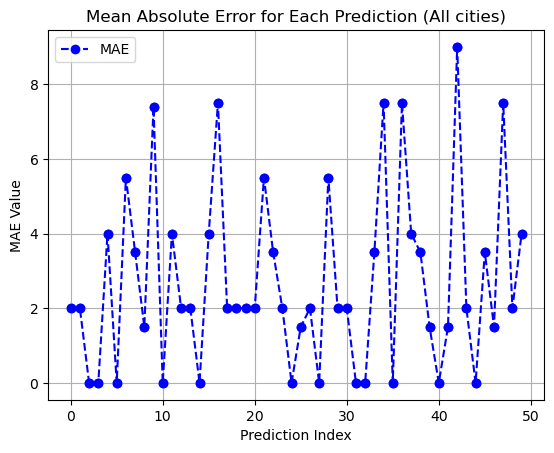

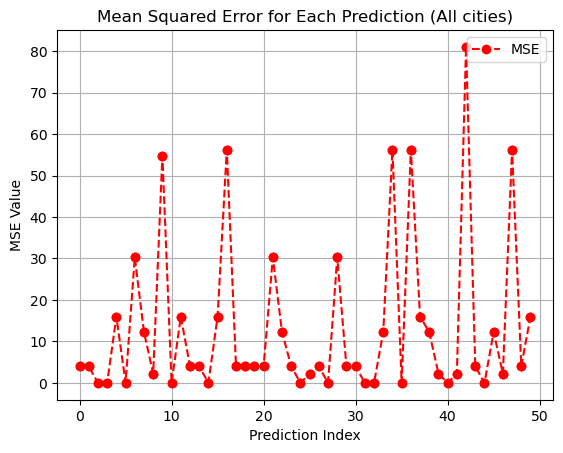

MAE all cities: 2.718
MSE all cities: 13.200200000000002
R^2 all cities: 0.9467992529567559


In [131]:
y_true = np.array([78.5, 81.5, 79.5, 80.5, 82.5, 81.5, 85, 78.5, 81.5, 75.6, 81, 82.5, 54.5, 61.5, 43, 48.5, 54, 49.5, 52.5, 54.5, 57.5, 42.5, 45.5, 47.5, 52.5, 32, 45.5, 47, 60.5, 44.5, 50.5, 49.5, 43, 40.5, 41, 50, 58.5, 81.5, 80, 67, 52, 71, 91, 83.5, 75.5, 67.5, 67, 78.5, 72.5, 65.5])
y_pred = np.array([76.5, 79.5, 79.5, 80.5, 78.5, 81.5, 79.5, 82, 83, 83, 81, 78.5, 52.5, 59.5, 43, 44.5, 46.5, 51.5, 54.5, 52.5, 55.5, 48, 49, 49.5, 52.5, 30.5, 47.5, 47, 55, 46.5, 48.5, 49.5, 43, 44, 48.5, 50, 51, 85.5, 83.5, 65.5, 52, 72.5, 82, 81.5, 75.5, 71, 68.5, 71, 70.5, 69.5])

mae_values = np.abs(y_true - y_pred)
mse_values = (y_true - y_pred) ** 2

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Plotting

# All cities
plt.scatter(range(len(mae_values)), mae_values, color='blue')
plt.plot(mae_values, label='MAE', linestyle='--', marker='o', color='blue')
plt.title('Mean Absolute Error for Each Prediction (All cities)')
plt.xlabel('Prediction Index')
plt.ylabel('MAE Value')
plt.grid(True)
plt.legend()
plt.show()

plt.scatter(range(len(mse_values)), mse_values, color='red')
plt.plot(mse_values, label='MSE', linestyle='--', marker='o', color='red')
plt.title('Mean Squared Error for Each Prediction (All cities)')
plt.xlabel('Prediction Index')
plt.ylabel('MSE Value')
plt.grid(True)
plt.legend()
plt.show()

print("MAE all cities:", mae)
print("MSE all cities:", mse)
print("R^2 all cities:", r2)

The results for the model evaluation give mixed results, but overall the model is considered to be successful at predicting the next day's maximum temperature for the 4 cities. Overall, combining predictions and true values for the 4 cities, the graphs of MAE and MSE show multiple peaks, showing little consistency with the  accuracy of the model. There is a clear decrease in both MSE and MAE with the introduction of the MLP Regressor, but these errors spike some time after, with the largest error in prediction occurring towards the end of the graphs, when the model already was at its peak complexity and the 5 sources were being used for prediction. This can be due to weather anomalies that make the true temperature deviate from the expected or due to the model and its quality. The remaining analysis will help clarify this unknown. Looking at the scale of the MAE, the error was never greater than 8 degrees farenheit, which is okay (not great) for a temperature prediction. But additionally, 31 predictions were in the MAE error range of 0-2 degrees farenheit, while 19 were above that range, and only 9 were above the 5 degrees farenheit error range. This shows the model is actually successful in predicting temperature with an acceptable (good) accuracy. In the graph for MSE, it is more evident how few outliers (big errors) there are, and how concentrated towards the lower end of the y-axis the errors are, which is a very good sign for overall model performance. The overall MAE and MSE values, 2.72 and 13.2 respectively, also show great model performance. Predicting the next day's temperature with an average error of 2.7 degrees (above or below) is a good result due to the natural unexpected variability of weather. Finally, the R^2 value for the combination of all cities is 0.947, which is an excellent value for this model, and one that clearly shows a great fit of the predictions with the true values, and a great correlation between the variance of the predictions and the features used, which is also a great sign of the quality of the model.

### Miami

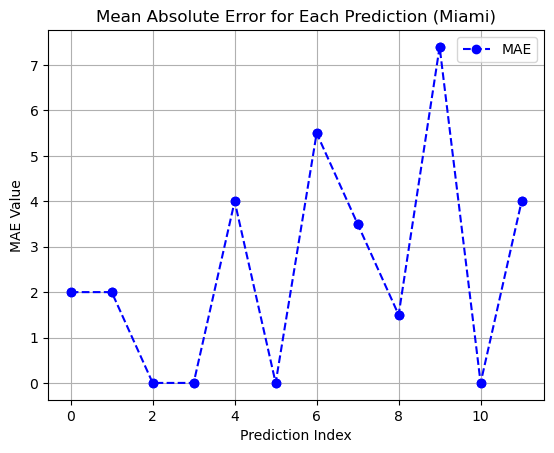

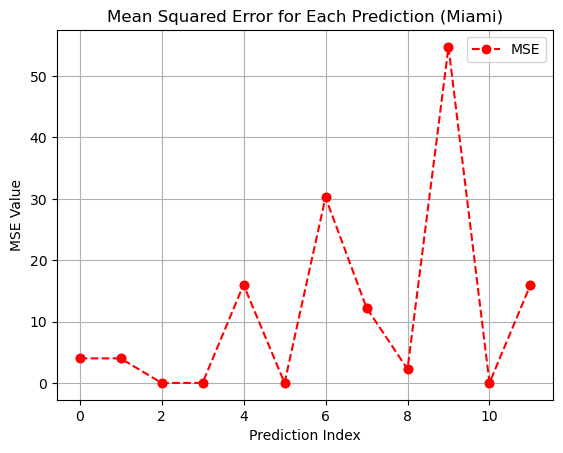

MAE Miami: 2.491666666666667
MSE Miami: 11.62583333333334
R^2 Miami: -1.1750009743929524


In [132]:
y_true_mia = np.array([78.5, 81.5, 79.5, 80.5, 82.5, 81.5, 85, 78.5, 81.5, 75.6, 81, 82.5])

y_pred_mia = np.array([76.5, 79.5, 79.5, 80.5, 78.5, 81.5, 79.5, 82, 83, 83, 81, 78.5])

mae_vals_mia = np.abs(y_true_mia - y_pred_mia)

mse_vals_mia = (y_true_mia - y_pred_mia) ** 2

mae_mia = mean_absolute_error(y_true_mia, y_pred_mia)

mse_mia = mean_squared_error(y_true_mia, y_pred_mia)

r2_mia = r2_score(y_true_mia, y_pred_mia)

# Plotting

# Miami
plt.scatter(range(len(mae_vals_mia)), mae_vals_mia, color='blue')
plt.plot(mae_vals_mia, label='MAE', linestyle='--', marker='o', color='blue')
plt.title('Mean Absolute Error for Each Prediction (Miami)')
plt.xlabel('Prediction Index')
plt.ylabel('MAE Value')
plt.grid(True)
plt.legend()
plt.show()

plt.scatter(range(len(mse_vals_mia)), mse_vals_mia, color='red')
plt.plot(mse_vals_mia, label='MSE', linestyle='--', marker='o', color='red')
plt.title('Mean Squared Error for Each Prediction (Miami)')
plt.xlabel('Prediction Index')
plt.ylabel('MSE Value')
plt.grid(True)
plt.legend()
plt.show()

print("MAE Miami:", mae_mia)
print("MSE Miami:", mse_mia)
print("R^2 Miami:", r2_mia)

The predictions made by the model for the city of Miami displayed the most erratic behavior in their error. But looking at the graphs for the MAE and MSE values, there were 4 hits where the prediction matched the true value and 8 misses. Out of these misses, only 2 were outside of the 0 to 5 degrees farenheit range, which is a positive sign, and 3 of the 8 misses were inside the 0 to 2 degrees farenheit range, which is also acceptable. The MAE for all the predictions was 2.49, which again, shows great accuracy for the model since an average error of 2.5 degrees farenheit is very good for temperature predictions. MSE values show only 1 big outlier and another intermediate outlier, which is good but could be improved. On the other hand, the R^2 value for Miami is far from expected. A negative R^2 value means the model would be better off predicting the mean of the true values, which is extremely negative for any machine learning model. At the moment, there is little certainty about why this is happening and how this could be improved, but the overall result is still very positive from the MAE and MSE values.

### New York City

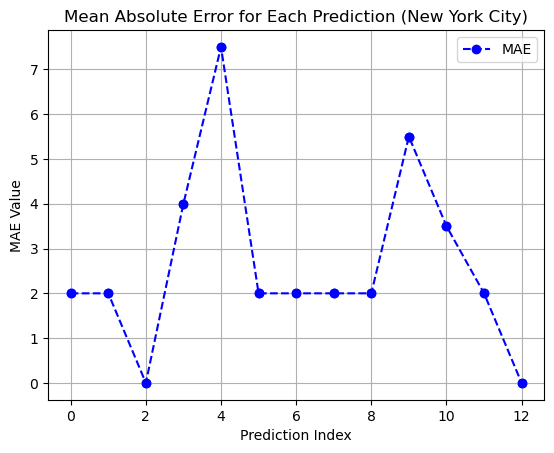

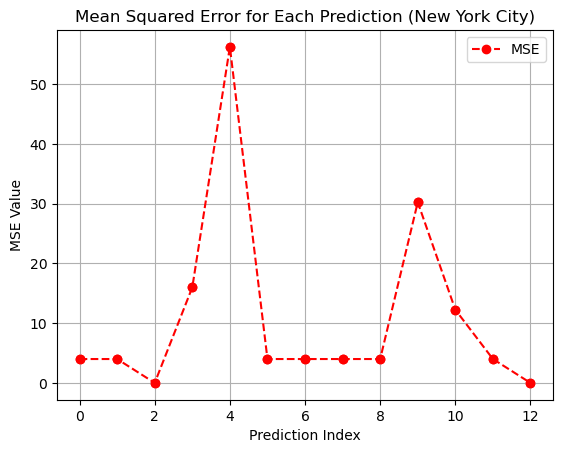

MAE New York City: 2.6538461538461537
MSE New York City: 10.98076923076923
R^2 New York City: 0.6220853273597393


In [133]:
y_true_nyc = np.array([54.5, 61.5, 43, 48.5, 54, 49.5, 52.5, 54.5, 57.5, 42.5, 45.5, 47.5, 52.5])

y_pred_nyc = np.array([52.5, 59.5, 43, 44.5, 46.5, 51.5, 54.5, 52.5, 55.5, 48, 49, 49.5, 52.5])

mae_vals_nyc = np.abs(y_true_nyc - y_pred_nyc)

mse_vals_nyc = (y_true_nyc - y_pred_nyc) ** 2

mae_nyc = mean_absolute_error(y_true_nyc, y_pred_nyc)

mse_nyc = mean_squared_error(y_true_nyc, y_pred_nyc)

r2_nyc = r2_score(y_true_nyc, y_pred_nyc)

# Plotting

# New York City
plt.scatter(range(len(mae_vals_nyc)), mae_vals_nyc, color='blue')
plt.plot(mae_vals_nyc, label='MAE', linestyle='--', marker='o', color='blue')
plt.title('Mean Absolute Error for Each Prediction (New York City)')
plt.xlabel('Prediction Index')
plt.ylabel('MAE Value')
plt.grid(True)
plt.legend()
plt.show()

plt.scatter(range(len(mse_vals_nyc)), mse_vals_nyc, color='red')
plt.plot(mse_vals_nyc, label='MSE', linestyle='--', marker='o', color='red')
plt.title('Mean Squared Error for Each Prediction (New York City)')
plt.xlabel('Prediction Index')
plt.ylabel('MSE Value')
plt.grid(True)
plt.legend()
plt.show()

print("MAE New York City:", mae_nyc)
print("MSE New York City:", mse_nyc)
print("R^2 New York City:", r2_nyc)

For the city of New York, the results were positive. Even though there were only 2 hits in the predictions, MAE shows 9 out of 13 predictions inside the 0 to 2 degrees farenheit range, which is a positive result. Only 2 predictions were outside the 0 to 5 degrees farenheit range. MSE values show one big outlier and another intermediate outlier, which is good but could be improved. MAE and MSE overall values, 2.65 and 10.98 respectively, show positive results for temperature prediction with few outliers. The R^2 value for New York City , 0.62, shows acceptable fit between the predictions and the true values, but its still lower than expected. These results for a specific city show mixed results, some are very good (MSE and MAE) but some are just acceptable (R^2), and to improve the model, these would have to be addressed city by city, but with the results of the overall model combining the 4 cities, the model shows good performance. 

### Chicago

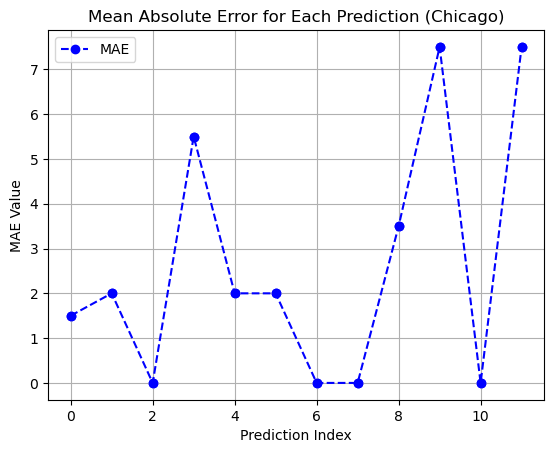

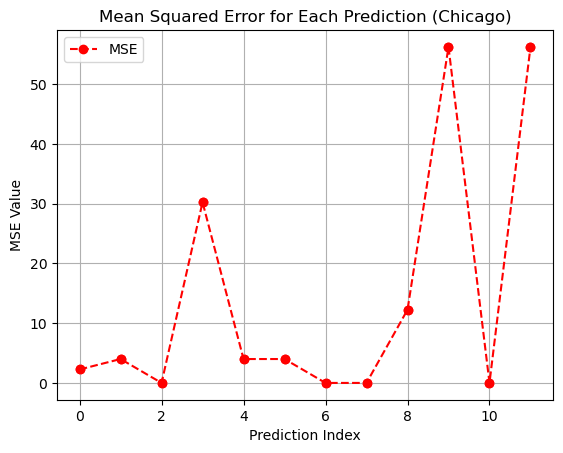

MAE Chicago: 2.625
MSE Chicago: 14.104166666666666
R^2 Chicago: 0.7472230000933445


In [134]:
y_true_chi = np.array([32, 45.5, 47, 60.5, 44.5, 50.5, 49.5, 43, 40.5, 41, 50, 58.5])

y_pred_chi = np.array([30.5, 47.5, 47, 55, 46.5, 48.5, 49.5, 43, 44, 48.5, 50, 51])

mae_vals_chi = np.abs(y_true_chi - y_pred_chi)

mse_vals_chi = (y_true_chi - y_pred_chi) ** 2

mae_chi = mean_absolute_error(y_true_chi, y_pred_chi)

mse_chi = mean_squared_error(y_true_chi, y_pred_chi)

r2_chi = r2_score(y_true_chi, y_pred_chi)

# Plotting

# Chicago
plt.scatter(range(len(mae_vals_chi)), mae_vals_chi, color='blue')
plt.plot(mae_vals_chi, label='MAE', linestyle='--', marker='o', color='blue')
plt.title('Mean Absolute Error for Each Prediction (Chicago)')
plt.xlabel('Prediction Index')
plt.ylabel('MAE Value')
plt.grid(True)
plt.legend()
plt.show()

plt.scatter(range(len(mse_vals_chi)), mse_vals_chi, color='red')
plt.plot(mse_vals_chi, label='MSE', linestyle='--', marker='o', color='red')
plt.title('Mean Squared Error for Each Prediction (Chicago)')
plt.xlabel('Prediction Index')
plt.ylabel('MSE Value')
plt.grid(True)
plt.legend()
plt.show()

print("MAE Chicago:", mae_chi)
print("MSE Chicago:", mse_chi)
print("R^2 Chicago:", r2_chi)

Chicago shows an interesting behavior, even though there are more outliers relative to the other cities (3), the rest of the predictions are mostly inside the 0 to 2 degrees farenheit range (8 out of 12). MAE and MSE overall values, 2.63 and 14.1 respectively, show good performance for temperature predictions, with slightly elevated outlier numbers, but still good. The R^2 value (0.75) shows good fit between the predictions and the true values, which is a great indicator for accuracy and model quality, so the overall results for Chicago are positive.

### Austin

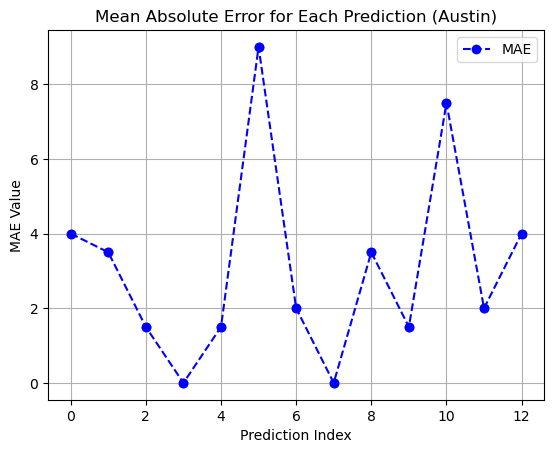

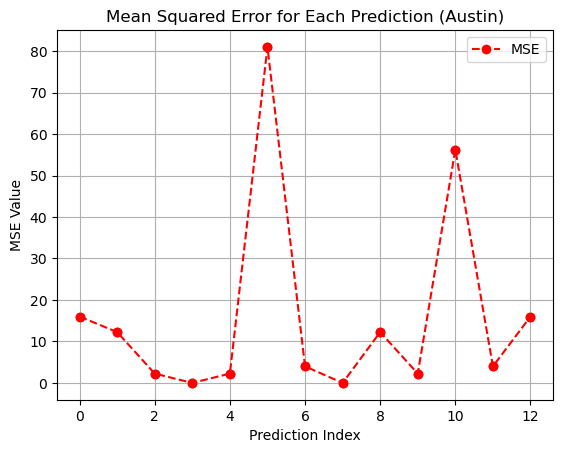

MAE Austin: 3.076923076923077
MSE Austin: 16.03846153846154
R^2 Austin: 0.8254949299855142


In [135]:
y_true_aus = np.array([81.5, 80, 67, 52, 71, 91, 83.5, 75.5, 67.5, 67, 78.5, 72.5, 65.5])

y_pred_aus = np.array([85.5, 83.5, 65.5, 52, 72.5, 82, 81.5, 75.5, 71, 68.5, 71, 70.5, 69.5])

mae_vals_aus = np.abs(y_true_aus - y_pred_aus)

mse_vals_aus = (y_true_aus - y_pred_aus) ** 2

mae_aus = mean_absolute_error(y_true_aus, y_pred_aus)

mse_aus = mean_squared_error(y_true_aus, y_pred_aus)

r2_aus = r2_score(y_true_aus, y_pred_aus)

# Plotting

# Austin
plt.scatter(range(len(mae_vals_aus)), mae_vals_aus, color='blue')
plt.plot(mae_vals_aus, label='MAE', linestyle='--', marker='o', color='blue')
plt.title('Mean Absolute Error for Each Prediction (Austin)')
plt.xlabel('Prediction Index')
plt.ylabel('MAE Value')
plt.grid(True)
plt.legend()
plt.show()

plt.scatter(range(len(mse_vals_aus)), mse_vals_aus, color='red')
plt.plot(mse_vals_aus, label='MSE', linestyle='--', marker='o', color='red')
plt.title('Mean Squared Error for Each Prediction (Austin)')
plt.xlabel('Prediction Index')
plt.ylabel('MSE Value')
plt.grid(True)
plt.legend()
plt.show()

print("MAE Austin:", mae_aus)
print("MSE Austin:", mse_aus)
print("R^2 Austin:", r2_aus)

Austin shows mixed results, almost opposite to other cities. MAE values are less clustered in the 0 to 2 degrees farenheit range (only 6 out of 12 predictions), but only 2 are outside the 0 to 5 degrees farenheit range, which is shown more evidently in the MSE values with the 2 obvious outliers. The sparsity in the lower end of the MAE values is shown in the overall MAE value, with 3.08 being the highest of all cities. MSE is also elevated, 16.04, which shows the 2 outliers are also fairly distanced from the rest of the predictions. The positive indicator comes from the MSE graph showing the vast majority of predictions in the lower end of the spectrum. On the other hand, the R^2 value of 0.83 is a very positive indicator of the model's performance for Austin and overall. This shows a great fit between predictions and true values and a great correlation between features and predicted values.

## Section 9: Automatic Trading With Kalshi API

In this section, the predictions are submitted to a Kalshi demo account in order to evaluate the model with a specific measurement. Connection was straightforward using the Kalshi API documentation. There were two important issues encountered with this API but they were both resolved quickly and had no impact on model testing. The first issue was the authentication stopped working suddenly, but luckily, the documentation gave a secondary authentication method. After switching to the secondary authentication method, everything was working again and it remained stable for the rest of the project. The second issue was there was one occasion in which the market information for the 4 tickers in question stopped returning the attributes: cap_strike and floor_strike, which were necessary to choose a specific prediction and submit. That day there was no prediction done on Kalshi, but the next day everything resolved on its own and stabilized for the rest of the project. The method used to execute trades is connecting to the API one time, and then for each city, using the general market ticker for Highest temperature for that city, the market options are requested for the date of 1 day into the future from the present day. These market options are parsed, comparing the prediction given by the model for that city with the option's attributes. When the right option is found, the ticker is saved in a variable and then an order is submitted for a set amount of contracts at a set price for the option matching the model's prediction. For version 2.0 of the model, the average of all predictions for each city was calculated here. This code is not necessary for the final model but the code was commented out for viewing and understanding the progress of this project.

### Establish Connection With the Kalshi API

In [136]:
config = kalshi_python.Configuration()
# Comment the line below to use production
config.host = 'https://demo-api.kalshi.co/trade-api/v2'

# Create an API configuration passing your credentials.
# Use this if you want the kalshi_python sdk to manage the authentication for you.
#kalshi_api = kalshi_python.ApiInstance(
    #email='nicolasrestrepog2506@gmail.com',
    #password='BostonU24.',
    #configuration=config,
#)

kalshi_api = kalshi_python.ApiInstance(
    configuration=config,
)
loginResponse = kalshi_api.login(LoginRequest(email='nicolasrestrepog2506@gmail.com', password='BostonU24.'))
token = loginResponse.token
kalshi_api.set_api_token(loginResponse.token)

# Checks if the exchange is available.
exchangeStatus = kalshi_api.get_exchange_status()
print('Exchange status response: ')
pprint(exchangeStatus)

# Gets the balance for your kalshi account.
balanceResponse = kalshi_api.get_balance()
print('\nUser balance: ')
pprint(balanceResponse)

Exchange status response: 
{'exchange_active': True, 'trading_active': True}

User balance: 
{'balance': 998064}


In [138]:
tomorrow_day = pd.Timestamp.now().day + 1
if(tomorrow_day == 32):
    tomorrow_day = 1
print(tomorrow_day)

1


### New York Trade

In [145]:
#print(f'pred_nyc_2_ss: {pred_nyc_2_ss}')
#print(f'pred_nyc_2_mm: {pred_nyc_2_mm}')

#print(f'pred_nyc_3_ss: {pred_nyc_3_ss}')
#print(f'pred_nyc_3_mm: {pred_nyc_3_mm}')

#print(f'pred_nyc_5_ss: {pred_nyc_5_ss}')
#print(f'pred_nyc_5_mm: {pred_nyc_5_mm}')

#preds = np.array([pred_nyc_2_ss, pred_nyc_2_mm, pred_nyc_3_ss, pred_nyc_3_mm, pred_nyc_5_ss, pred_nyc_5_mm])

#final_pred = np.mean(preds)

final_pred = ny_pred
print(final_pred)

# Gets the data for a specific event.
eventTicker = ''
if tomorrow_day < 10:
    eventTicker = f'HIGHNY-24APR0{tomorrow_day}'
else:
    eventTicker = f'HIGHNY-24APR{tomorrow_day}'
eventResponse = kalshi_api.get_event(eventTicker)

markets = eventResponse.markets

ticker = ''
chosen_market = None

for market in markets:
    
    if(market.floor_strike == None):
        if(market.cap_strike >= int(final_pred)):
            chosen_market = market
            break
    elif(market.cap_strike == None):
        if(market.floor_strike <= int(final_pred)):
            chosen_market = market
            break
    else:
        if(market.cap_strike >= int(final_pred) and market.floor_strike <= int(final_pred)):
            chosen_market = market
            break

if exchangeStatus.trading_active:
    orderUuid = str(uuid.uuid4())
    orderResponse = kalshi_api.create_order(CreateOrderRequest(
        ticker=chosen_market.ticker,
        action='buy',
        type='limit',
        yes_price=10,
        count=10,
        client_order_id=orderUuid,
        side='yes',
    ))
    print('\nOrder submitted: ')
    pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')

48.52383991186423

Order submitted: 
{'order': {'action': 'buy',
           'client_order_id': '4d23822b-894c-4c95-960d-1a016e8663fc',
           'created_time': '2024-03-31T14:46:40.682044Z',
           'expiration_time': None,
           'no_price': 90,
           'order_id': '34965aca-def8-40a8-bb34-558799d79ada',
           'side': 'yes',
           'status': 'resting',
           'ticker': 'HIGHNY-24APR01-T48',
           'type': 'limit',
           'user_id': '5c67ef25-dc7f-4706-94c2-da3e9b6c6edd',
           'yes_price': 10}}


### Miami Trade

In [146]:
#print(f'pred_mia_2_ss: {pred_mia_2_ss}')
#print(f'pred_mia_2_mm: {pred_mia_2_mm}')

#print(f'pred_mia_3_ss: {pred_mia_3_ss}')
#print(f'pred_mia_3_mm: {pred_mia_3_mm}')

#print(f'pred_mia_5_ss: {pred_mia_5_ss}')
#print(f'pred_mia_5_mm: {pred_mia_5_mm}')

#preds = np.array([pred_mia_2_ss, pred_mia_2_mm, pred_mia_3_ss, pred_mia_3_mm, pred_mia_5_ss, pred_mia_5_mm])

#final_pred = np.mean(preds)

final_pred = miami_pred
print(final_pred)

# Gets the data for a specific event.
eventTicker = ''
if tomorrow_day < 10:
    eventTicker = f'HIGHMIA-24APR0{tomorrow_day}'
else:
    eventTicker = f'HIGHMIA-24APR{tomorrow_day}'
eventResponse = kalshi_api.get_event(eventTicker)

markets = eventResponse.markets

ticker = ''
chosen_market = None

for market in markets:
    
    if(market.floor_strike == None):
        if(market.cap_strike >= int(final_pred)):
            chosen_market = market
            break
    elif(market.cap_strike == None):
        if(market.floor_strike <= int(final_pred)):
            chosen_market = market
            break
    else:
        if(market.cap_strike >= int(final_pred) and market.floor_strike <= int(final_pred)):
            chosen_market = market
            break

if exchangeStatus.trading_active:
    orderUuid = str(uuid.uuid4())
    orderResponse = kalshi_api.create_order(CreateOrderRequest(
        ticker=chosen_market.ticker,
        action='buy',
        type='limit',
        yes_price=10,
        count=10,
        client_order_id=orderUuid,
        side='yes',
    ))
    print('\nOrder submitted: ')
    pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')

89.38382985416425

Order submitted: 
{'order': {'action': 'buy',
           'client_order_id': '133189d9-4b45-4d83-815d-dbdd9debad4f',
           'created_time': '2024-03-31T14:47:43.220373Z',
           'expiration_time': None,
           'no_price': 90,
           'order_id': 'fa006b8a-3e32-4d71-95de-8365e58af512',
           'side': 'yes',
           'status': 'resting',
           'ticker': 'HIGHMIA-24APR01-T83',
           'type': 'limit',
           'user_id': '5c67ef25-dc7f-4706-94c2-da3e9b6c6edd',
           'yes_price': 10}}


### Chicago Trade

In [147]:
#print(f'pred_chi_2_ss: {pred_chi_2_ss}')
#print(f'pred_chi_2_mm: {pred_chi_2_mm}')

#print(f'pred_chi_3_ss: {pred_chi_3_ss}')
#print(f'pred_chi_3_mm: {pred_chi_3_mm}')

#print(f'pred_chi_5_ss: {pred_chi_5_ss}')
#print(f'pred_chi_5_mm: {pred_chi_5_mm}')

#preds = np.array([pred_chi_2_ss, pred_chi_2_mm, pred_chi_3_ss, pred_chi_3_mm, pred_chi_5_ss, pred_chi_5_mm])

#final_pred = np.mean(preds)
#print(final_pred)

final_pred = chicago_pred
print(final_pred)

# Gets the data for a specific event.
eventTicker = ''
if tomorrow_day < 10:
    eventTicker = f'HIGHCHI-24APR0{tomorrow_day}'
else:
    eventTicker = f'HIGHCHI-24APR{tomorrow_day}'
eventResponse = kalshi_api.get_event(eventTicker)

markets = eventResponse.markets

ticker = ''
chosen_market = None

for market in markets:
    
    if(market.floor_strike == None):
        if(market.cap_strike >= int(final_pred)):
            chosen_market = market
            break
    elif(market.cap_strike == None):
        if(market.floor_strike <= int(final_pred)):
            chosen_market = market
            break
    else:
        if(market.cap_strike >= int(final_pred) and market.floor_strike <= int(final_pred)):
            chosen_market = market
            break

if exchangeStatus.trading_active:
    orderUuid = str(uuid.uuid4())
    orderResponse = kalshi_api.create_order(CreateOrderRequest(
        ticker=chosen_market.ticker,
        action='buy',
        type='limit',
        yes_price=10,
        count=10,
        client_order_id=orderUuid,
        side='yes',
    ))
    print('\nOrder submitted: ')
    pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')

52.77761207357023

Order submitted: 
{'order': {'action': 'buy',
           'client_order_id': 'c42ba075-fb7c-45a2-99ac-3aca0aa7da5b',
           'created_time': '2024-03-31T14:48:08.555279Z',
           'expiration_time': None,
           'no_price': 90,
           'order_id': '3f064fe6-ade1-4fcb-8497-a0a218803374',
           'side': 'yes',
           'status': 'resting',
           'ticker': 'HIGHCHI-24APR01-T49',
           'type': 'limit',
           'user_id': '5c67ef25-dc7f-4706-94c2-da3e9b6c6edd',
           'yes_price': 10}}


### Austin Trade

In [148]:
#print(f'pred_aus_2_ss: {pred_aus_2_ss}')
#print(f'pred_aus_2_mm: {pred_aus_2_mm}')

#print(f'pred_aus_3_ss: {pred_aus_3_ss}')
#print(f'pred_aus_3_mm: {pred_aus_3_mm}')

#print(f'pred_aus_5_ss: {pred_aus_5_ss}')
#print(f'pred_aus_5_mm: {pred_aus_5_mm}')

#preds = np.array([pred_aus_2_ss, pred_aus_2_mm, pred_aus_3_ss, pred_aus_3_mm, pred_aus_5_ss, pred_aus_5_mm])

#final_pred = np.mean(preds)
#print(final_pred)

final_pred = austin_pred
print(final_pred)

# Gets the data for a specific event.
eventTicker = ''
if tomorrow_day < 10:
    eventTicker = f'HIGHAUS-24APR0{tomorrow_day}'
else:
    eventTicker = f'HIGHAUS-24APR{tomorrow_day}'
eventResponse = kalshi_api.get_event(eventTicker)

markets = eventResponse.markets

ticker = ''
chosen_market = None

for market in markets:
    
    if(market.floor_strike == None):
        if(market.cap_strike >= int(final_pred)):
            chosen_market = market
            break
    elif(market.cap_strike == None):
        if(market.floor_strike <= int(final_pred)):
            chosen_market = market
            break
    else:
        if(market.cap_strike >= int(final_pred) and market.floor_strike <= int(final_pred)):
            chosen_market = market
            break

if exchangeStatus.trading_active:
    orderUuid = str(uuid.uuid4())
    orderResponse = kalshi_api.create_order(CreateOrderRequest(
        ticker=chosen_market.ticker,
        action='buy',
        type='limit',
        yes_price=10,
        count=10,
        client_order_id=orderUuid,
        side='yes',
    ))
    print('\nOrder submitted: ')
    pprint(orderResponse)
else:
    print('\nThe exchange is not trading active, no orders will be sent right now.')

76.29131145910945

Order submitted: 
{'order': {'action': 'buy',
           'client_order_id': 'f0280120-d72d-4b3b-8332-425b653a0fd1',
           'created_time': '2024-03-31T14:48:24.323547Z',
           'expiration_time': None,
           'no_price': 90,
           'order_id': '941e6924-6b44-465a-b140-8a54075c7141',
           'side': 'yes',
           'status': 'resting',
           'ticker': 'HIGHAUS-24APR01-T83',
           'type': 'limit',
           'user_id': '5c67ef25-dc7f-4706-94c2-da3e9b6c6edd',
           'yes_price': 10}}
